<a href="https://colab.research.google.com/github/xh313/compchem/blob/main/MLR_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modified based on the original Jupyter Notebook Mattlab_MLR_Modeling_v5.1.2

# Table of Contents

* [Import and Load Data](#im_load)
    * [Import](#im)
    * [Load Data (Single File)](#load)
* [Basic Plots](#basic)
    * [Plot Experimental vs Self](#exp_self)
    * [Univariate Correlations](#univar_corr)
    * [Seaborn](#seaborn)
    * [Plot Feature vs Feature](#2feature)
    * [Correlation Map](#corr_map)
* [Remove Colinear Descriptors](#colinear)
    * [Identify Only](#ident_colinear)
    * [Automatically Remove](#auto_colinear)
    * [Manually Remove](#manual_colinear)
* [Thresholds](#thresh)
    * [Single-Node Regression](#single_node)
    * [Classify Highest and Lowest Group](#classify_group)
    * [Classify by Value](#classify_val)
    * [Property Threshold](#prop_thresh)
* [Data preparation](#prep)
    * [Manual Preselection](#presel)
    * [Training/Test Split](#split)
    * [Scaling](#scale)
    * [Add Cross-Terms](#crosst)
* [Linear Modeling](#linear)
    * [Manual Model Selection](#linear_manual)
        * [Add Features](#linear_manual_add)
        * [Remove Features](#linear_manual_del)
    * [Multivariate Model Search](#linear_search)
        * [Sort Models](#linear_search_sort)
            * [Sort by Training Correlation](#linear_search_sort_t)
            * [Count Number of Times Each Feature Appears](#linear_search_count)
            * [Sort by Number of Terms](#linear_search_sort_n)
            * [Find Least Offensive Models](#linear_search_sort_least)
        * [Filter by Feature](#linear_search_filter)
        * [View Other Models](#linear_search_view)
    * [Ridge Regression](#linear_ridge)
    * [Lasso Feature Selection](#linear_lasso)
    * [Elastic Net](#linear_elastic)
    * [Orthogonal Matching Pursuit](#linear_orthog)
* [Non-Linear Modeling](#nonlinear)

# Import and Load Data <a class="anchor" id="im_load"></a>

## Import <a class="anchor" id="im"></a>

In [24]:
!pip install adjustText
!wget 'https://github.com/xh313/compchem/raw/main/MLR_fwd_stepwise_scripts/ForwardStepCandidates_2.py'
!wget 'https://github.com/xh313/compchem/raw/main/MLR_fwd_stepwise_scripts/loo_q2.py'
!wget 'https://github.com/xh313/compchem/raw/main/MLR_fwd_stepwise_scripts/forwardselect_q5.py'
!wget 'https://github.com/xh313/compchem/raw/main/MLR_fwd_stepwise_scripts/stepwise_selection2.py'
!wget 'https://github.com/xh313/compchem/raw/main/MLR_fwd_stepwise_scripts/kennardstonealgorithm.py'
!wget 'https://github.com/xh313/compchem/raw/main/MLR_fwd_stepwise_scripts/Amide_Project_Modeling_Spreadsheet.xlsx'

import os, re, sys, pickle, datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sns
import pandas as pd
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from adjustText import adjust_text

import statsmodels.api as sm
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed

import warnings
warnings.filterwarnings("ignore")

import loo_q2 as loo

randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[],VSlabels=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5),
               dpi=180)
    # plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker=".",facecolor='none',s=200)
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker=".",s=200) # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color='red',marker=".",linewidth=3, s=200)     #,alpha=0.25  "#8da9f5"
    plt.plot(y_train,yy_fit_line,color="darkgrey",linestyle='-',dashes=[5,15]) #,alpha=0.2
    if leg:
        plt.legend(#loc='lower right', 
                   fontsize=10,
                   frameon=False)
    plt.xlabel(label+" measured",fontsize=16, fontweight='bold')
    plt.ylabel(label+" predicted",fontsize=16, fontweight='bold')
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    sns.despine(offset=10, trim=True)
    
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    
    if VSlabels:
        texts = [plt.text(y_test[i], y_pred_test[i], VSlabels[i]) for i in range(len(VSlabels))]
        adjust_text(texts)
    
    
    if not sav:
        plt.show()  
    else:
        plt.savefig('result.svg', 
                    dpi=300, 
                    bbox_inches='tight', transparent=True)
        plt.show()

    
        
def r2_val(y_test,y_pred_test,y_train):
    """Calculates the external R2 pred as described:
    https://pdfs.semanticscholar.org/4eb2/5ff5a87f2fd6789c5b9954eddddfd1c59dab.pdf"""
    y_resid = y_pred_test - y_test
    SS_resid = np.sum(y_resid**2)
    y_var = y_test - np.mean(y_train)
    SS_total = np.sum(y_var**2)
    r2_validation = 1-SS_resid/SS_total
    return(r2_validation)

def repeated_k_fold(X_train,y_train,reg = LinearRegression(), k=3, n=100):
    """Reapeated k-fold cross-validation. 
    For each of n repeats, the (training)data is split into k folds. 
    For each fold, this part of the data is predicted using the rest. 
    Once this is done for all k folds, the coefficient of determination (R^2) of the predictions of all folds combined (= the complete data set) is evaluated
    This is repeated n times and all n R^2 are returned for averaging/further analysis
    """
    
    rkf = RepeatedKFold(n_splits=k, n_repeats=n)
    r2_scores = []
    y_validations,y_predictions = np.zeros((np.shape(X_train)[0],n)),np.zeros((np.shape(X_train)[0],n))
    foldcount = 0
    for i,foldsplit in enumerate(rkf.split(X_train)):
        fold, rep = i%k, int(i/k) # Which of k folds. Which of n repeats
        model = reg.fit(X_train[foldsplit[0]],y_train[foldsplit[0]]) # foldsplit[0]: k-1 training folds
        y_validations[foldcount:foldcount+len(foldsplit[1]),rep] = y_train[foldsplit[1]] # foldsplit[1]: validation fold
        y_predictions[foldcount:foldcount+len(foldsplit[1]),rep]  = model.predict(X_train[foldsplit[1]])
        foldcount += len(foldsplit[1])
        if fold+1==k:
            foldcount = 0
    r2_scores = np.asarray([metrics.r2_score(y_validations[:,rep],y_predictions[:,rep]) for rep in range(n)])
    return(r2_scores)

# keepmodels = []

import random
insu = ["yikes. that's ass.","LMAO do not publish this what are you doing","oof.","that's a rough one","I'm embarassed to even print this, but here it is:","more disappointing than an unsalted pretzel","this model makes onions cry","did you get this model from Joe?","remember, these stats aren't an insult, they're just describing your model","this model reminds me - I gotta take out the trash","don't worry - the first 40 years of modeling are always the hardest","this model has miles to go before it reaches mediocre","the bad model store called. they're running out of your models"]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-07-20 20:30:59--  https://github.com/xh313/compchem/raw/main/MLR_fwd_stepwise_scripts/ForwardStepCandidates_2.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xh313/compchem/main/MLR_fwd_stepwise_scripts/ForwardStepCandidates_2.py [following]
--2022-07-20 20:30:59--  https://raw.githubusercontent.com/xh313/compchem/main/MLR_fwd_stepwise_scripts/ForwardStepCandidates_2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7881 (7.7K) [text/plain]
Saving to: ‘ForwardStepCandidates_2.py.5’

Forw

In [ ]:
# Font control
!wget 'https://github.com/xh313/TidyTuesdayWithPython/raw/main/Avenir.ttc'
font_files = fm.findSystemFonts('.')
# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)
    print(font_file)

# Use your new font on all your plots.
plt.rcParams.update({
  #"text.usetex": True,
  "font.family": "Avenir"
})

--2022-07-20 17:35:48--  https://github.com/xh313/TidyTuesdayWithPython/raw/main/Avenir.ttc
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xh313/TidyTuesdayWithPython/main/Avenir.ttc [following]
--2022-07-20 17:35:48--  https://raw.githubusercontent.com/xh313/TidyTuesdayWithPython/main/Avenir.ttc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1639536 (1.6M) [application/octet-stream]
Saving to: ‘Avenir.ttc.1’

Avenir.ttc.1        100%[===================>]   1.56M  --.-KB/s    in 0.009s  

2022-07-20 17:35:48 (180 MB/s) - ‘Avenir.ttc.1’ saved [1639536/1639536]

/content/Avenir.ttc


In [ ]:
#modules
#import sys, pathlib
#SCRIPT_DIR = str(pathlib.Path.cwd() / 'modeling_scripts')
#sys.path.insert(1, SCRIPT_DIR)
#import import_data as imp

## Load Data (Single File) <a class="anchor" id="load"></a>

In [ ]:
#modules
#excel_file = "Shaw_init_catalyst_models"
#excel_sheet = "benzyl+PMP"

#num_par = 102 # now number of x-params (x1-x101 = 101 params)
#num_samples = 33

#imp.single(excel_file,excel_sheet,num_par,num_samples)

In [ ]:
excel_file = "Amide_Project_Modeling_Spreadsheet"
excel_sheet = "interp_boltz_properties"
num_par = 163 # 1x-101x, num_par = 101
par_start_col = 5 # 0-indexed
num_samples = 44
response_col = 4 # 0-indexed
y_label_col = 0 # 0-indexed

apply_mask = True # remove samples with empty response
verbose = True
xlabelrow = True

all_params = num_par*num_samples

inp = pd.read_excel(excel_file+".xlsx",excel_sheet,header=0,index_col=y_label_col,nrows=num_samples+int(xlabelrow),
                    usecols=list(range(0,(num_par+par_start_col))))
    
if xlabelrow:
    X_names = list(inp.iloc[0,par_start_col-1:all_params+par_start_col-1])
    X_labels = list(inp.columns)[par_start_col-1:all_params+par_start_col-1]
    resp_label = list(inp.columns)[response_col-1]
    inp.drop(index=inp.index[0],inplace=True)
else:
    X_labels = list(inp.columns)[par_start_col-1:all_params+par_start_col-1]
    X_names = X_labels
    resp_label = list(inp.columns)[response_col-1]

X_labelname = [" ".join([str(a) for a in i]) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))
y = np.asarray(inp[resp_label],dtype=np.float)
X = np.asarray(inp[X_labels],dtype=np.float)
y_labels = np.asarray(list(inp.index),dtype=str)
y_labels_comp= y_labels


if apply_mask:
    mask = y.nonzero()[0]
    mask = ~np.isnan(y)
    print("n_samples before removing empty cells: {}".format(len(y)))
    print("Removing {} samples.".format(len(y)-sum(mask)))
    X = X[np.array(mask)]
    y = y[np.array(mask)]
    y_labels = y_labels[np.array(mask)]
X_all = X
if verbose:
    print("Shape X: {}".format(X.shape))
    print("Shape y: {}".format(y.shape)) 
    print("Shape labels: {}".format(y_labels.shape)) 
    print("First X cell: {}".format(X[0,0]))
    print("Last X cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label: {}".format(y_labels[-1]))
    #print(inp.head())

removed_feats = []

n_samples before removing empty cells: 44
Removing 0 samples.
Shape X: (44, 115)
Shape y: (44,)
Shape labels: (44,)
First X cell: -591.9190270460148
Last X cell:  70.70437797064479
First y: -4.216512196196308
Last y:  2.3052515348760885
Last label: Ac14-N13


In [43]:
inp

,y1,y2,y3,y4,x1,x2,x3,x4,x5,x6,...,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115
y0,,,,,,,,,,,,,,,,,,,,,
Ac13-N16,Ac13,N16,0.01475,-4.216512,-591.919027,-591.783776,-591.656669,-591.521418,5.705294,-0.268332,...,110.861,4.26617,1.925297,4.169822,3491.6191,3569.2888,1659.8304,52.316284,42.280461,72.268575
Ac9-N9,Ac9,N9,0.01835,-3.998126,-536.281059,-536.219651,-536.069189,-536.007781,4.52985,-0.332415,...,110.587706,7.000788,2.112936,6.679199,3498.188418,3578.940931,1655.721904,55.528833,45.990541,74.152499
Ac17-N14,Ac17,N14,0.0217,-3.830443,-537.716215,-537.576015,-537.472684,-537.332484,1.9899,-0.30174,...,110.46483,5.972255,1.925841,7.204349,3500.333536,3580.397126,1661.291581,50.213853,39.702417,71.077944
Ac5-N6,Ac5,N6,0.02705,-3.610068,-538.959352,-538.797585,-538.700496,-538.538728,1.954113,-0.302947,...,110.331356,5.65519,1.796887,7.079468,3498.705843,3576.484395,1663.59863,50.684697,39.584483,71.601932
Ac13-N1,Ac13,N1,0.0324,-3.429597,-591.919027,-591.783776,-591.656669,-591.521418,5.705294,-0.268332,...,110.419035,4.683214,1.741609,5.249353,3499.003928,3577.986452,1666.330071,48.784901,36.911262,70.764874
Ac17-N5,Ac17,N5,0.0335,-3.39621,-537.716215,-537.576015,-537.472684,-537.332484,1.9899,-0.30174,...,110.864549,5.181908,1.985045,3.76639,3492.095304,3570.955763,1657.058875,51.933754,41.363141,72.332758
Ac7-N14,Ac7,N14,0.03405,-3.379925,-424.611707,-424.460789,-424.403153,-424.252236,2.231661,-0.343703,...,110.46483,5.972255,1.925841,7.204349,3500.333536,3580.397126,1661.291581,50.213853,39.702417,71.077944
Ac6-N15,Ac6,N15,0.0634,-2.758291,-613.199362,-613.043438,-612.926196,-612.770271,1.657361,-0.35096,...,109.828128,5.562171,1.746078,6.007451,3498.603283,3578.306538,1662.699373,50.23413,38.851025,71.407896
Ac5-N2,Ac5,N2,0.0766,-2.569158,-538.959352,-538.797585,-538.700496,-538.538728,1.954113,-0.302947,...,111.266417,6.079421,1.7,5.885026,3503.287596,3584.246493,1664.033771,49.736382,38.439716,70.866844


# Basic Plots <a class="anchor" id="basic"></a>

## Plot Experimental vs Self <a class="anchor" id="exp_self"></a>

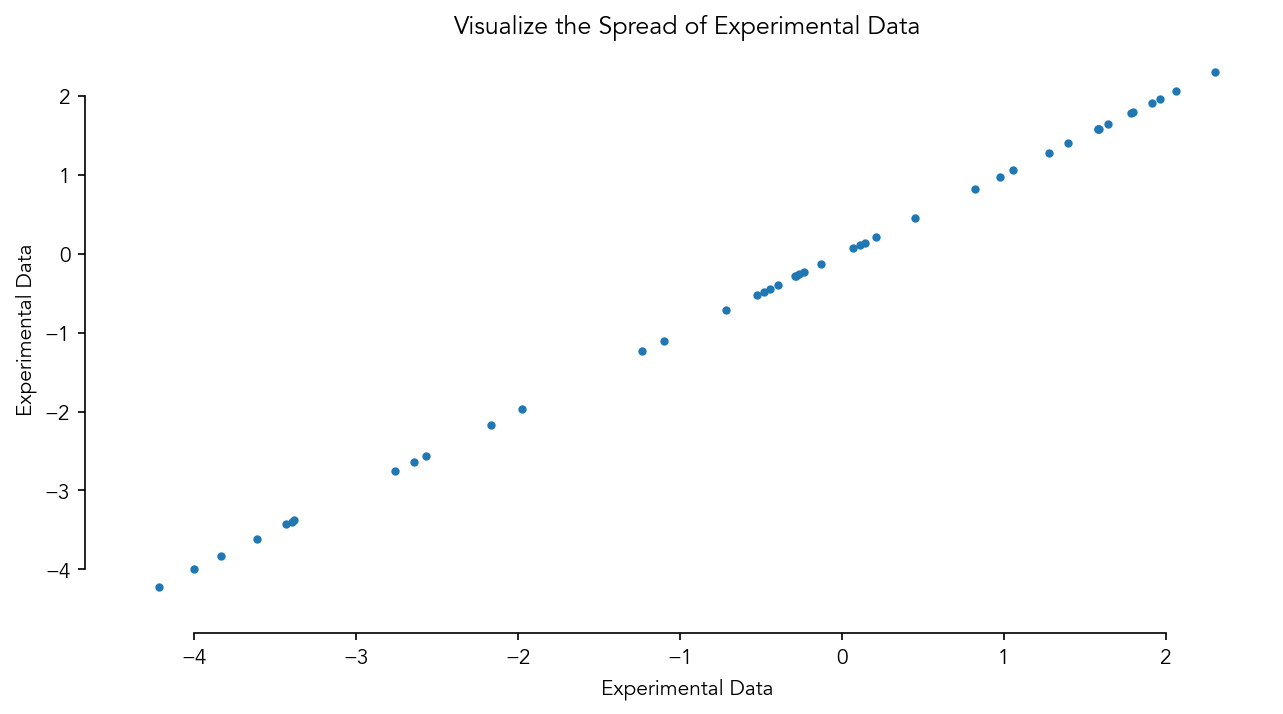

In [ ]:
from adjustText import adjust_text

plt.figure(figsize=(10,5), dpi=150)
plt.scatter(y,y,
            marker='.')
plt.title('Visualize the Spread of Experimental Data')
plt.xlabel('Experimental Data')
plt.ylabel('Experimental Data')
#labels = [plt.text(y[i],y[i],y_labels[i]) for i in range(len(y))]
#adjust_text(labels)
sns.despine(trim=True,
            offset=10)

plt.show()

## Univariate Correlations <a class="anchor" id="univar_corr"></a>

x1 e gas_acid_boltz


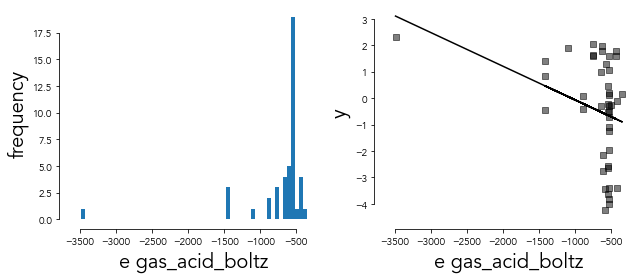

R^2 = 0.11; p-value = 0.03

-------------------------------------------------------------------------------

x2 g gas_acid_boltz


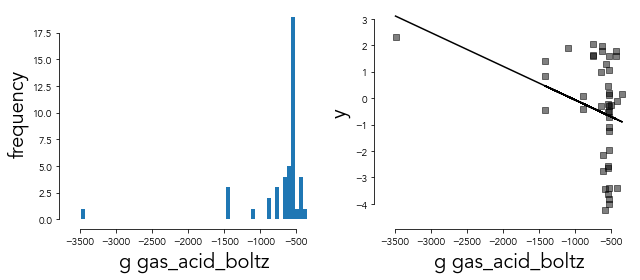

R^2 = 0.11; p-value = 0.03

-------------------------------------------------------------------------------

x3 E THF_acid_boltz


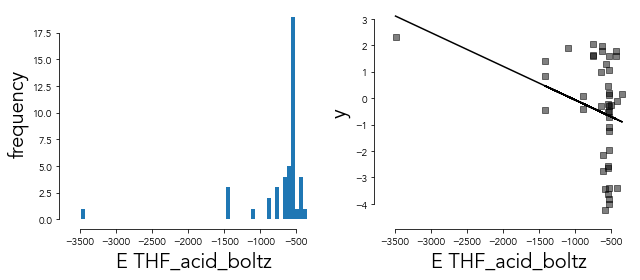

R^2 = 0.11; p-value = 0.03

-------------------------------------------------------------------------------

x4 G THF_acid_boltz


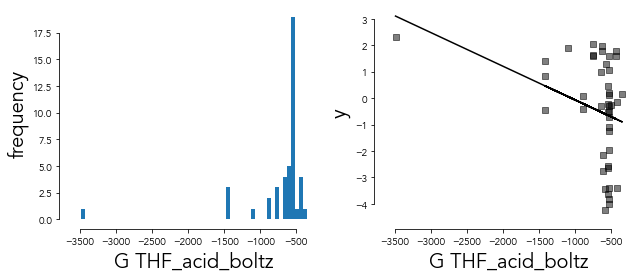

R^2 = 0.11; p-value = 0.03

-------------------------------------------------------------------------------

x5 dipole_acid_boltz


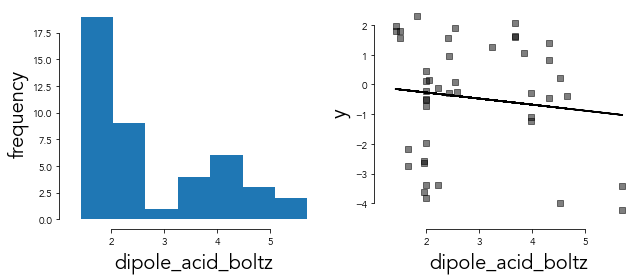

R^2 = 0.02; p-value = 0.42

-------------------------------------------------------------------------------

x6 E (HOMO)_acid_boltz


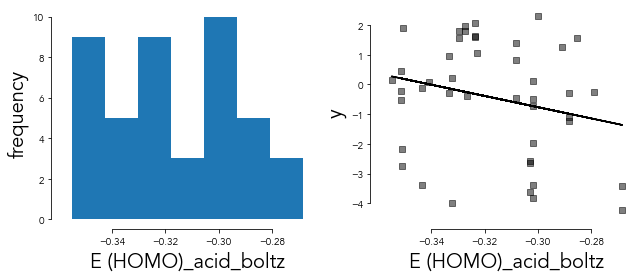

R^2 = 0.06; p-value = 0.12

-------------------------------------------------------------------------------

x7 E (LUMO)_acid_boltz


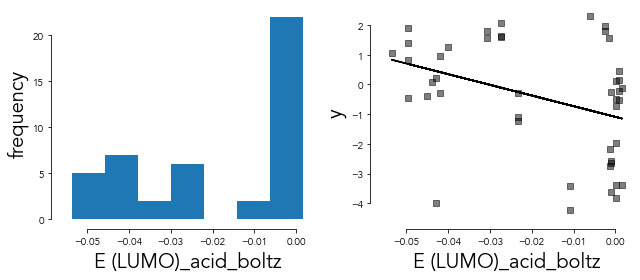

R^2 = 0.14; p-value = 0.01

-------------------------------------------------------------------------------

x8 mu_acid_boltz


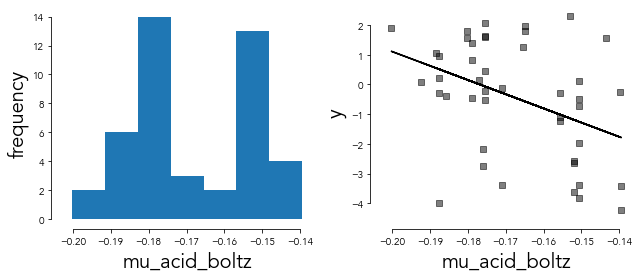

R^2 = 0.16; p-value = 6.96E-03

-------------------------------------------------------------------------------

x9 eta LUMO-HOMO_acid_boltz


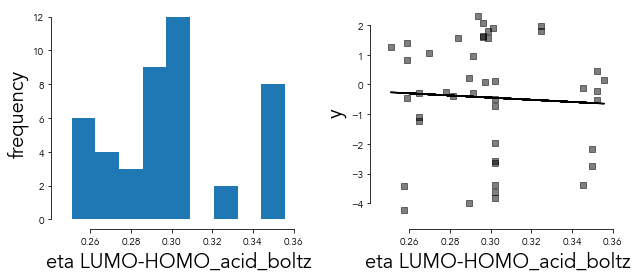

R^2 = 0.00; p-value = 0.72

-------------------------------------------------------------------------------

x10 omega_acid_boltz


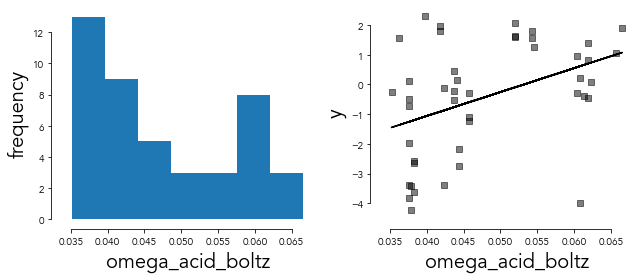

R^2 = 0.17; p-value = 5.75E-03

-------------------------------------------------------------------------------

x11 Polarizability (1)_acid_boltz


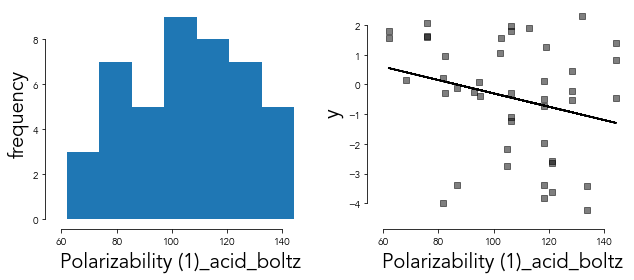

R^2 = 0.07; p-value = 0.09

-------------------------------------------------------------------------------

x12 NBO-C1 C=O_acid_boltz


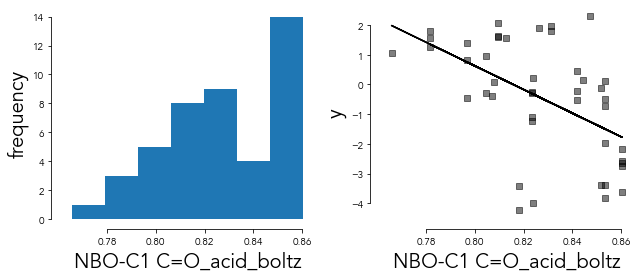

R^2 = 0.28; p-value = 2.49E-04

-------------------------------------------------------------------------------

x13 NBO-O2 C=O_acid_boltz


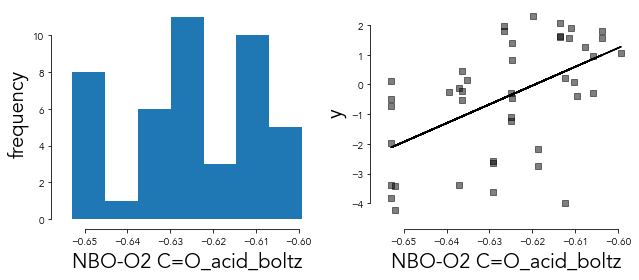

R^2 = 0.28; p-value = 2.21E-04

-------------------------------------------------------------------------------

x14 NBO-O3 O-H


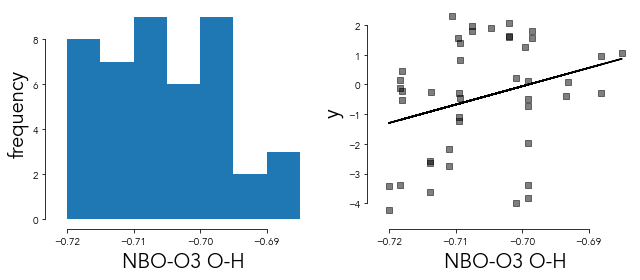

R^2 = 0.09; p-value = 0.05

-------------------------------------------------------------------------------

x15 NBO-C4_acid_boltz


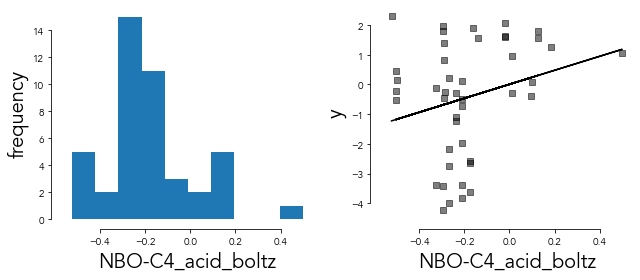

R^2 = 0.06; p-value = 0.10

-------------------------------------------------------------------------------

x16 NBO-H5 O-H_acid_boltz


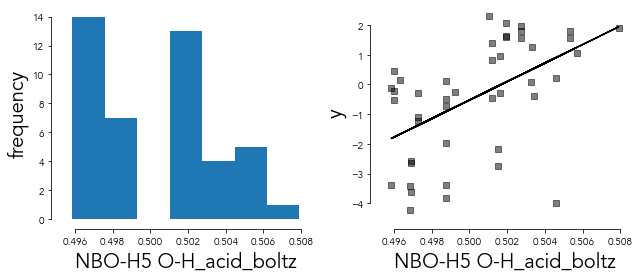

R^2 = 0.27; p-value = 3.04E-04

-------------------------------------------------------------------------------

x17 NMR-C1 C=O_acid_boltz


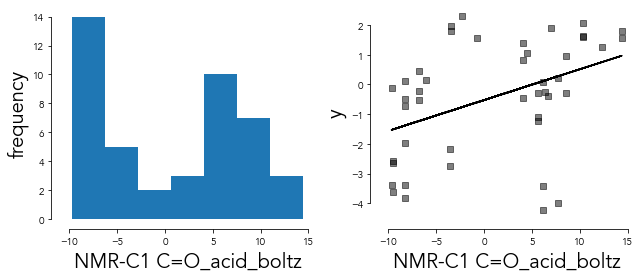

R^2 = 0.17; p-value = 4.74E-03

-------------------------------------------------------------------------------

x18 NMR-C4_acid_boltz


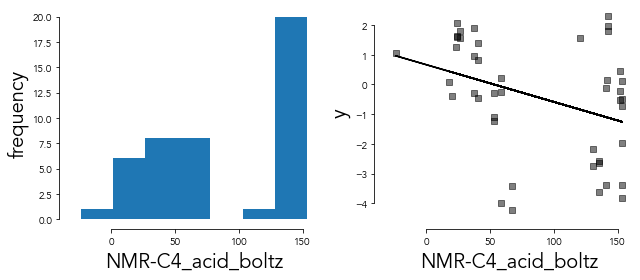

R^2 = 0.13; p-value = 0.02

-------------------------------------------------------------------------------

x19 NMR-H5 O-H_acid_boltz


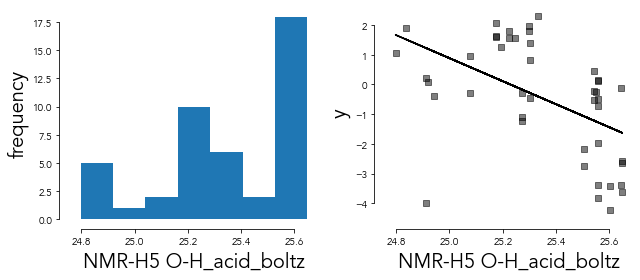

R^2 = 0.25; p-value = 5.26E-04

-------------------------------------------------------------------------------

x20 angle-O2-C1-C4_acid_boltz


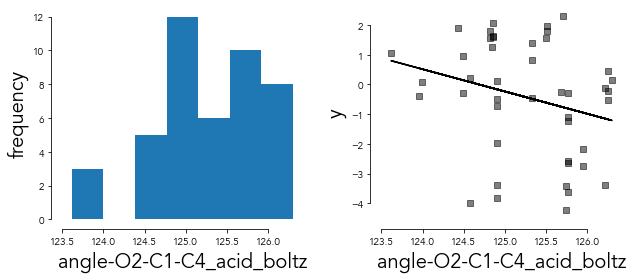

R^2 = 0.07; p-value = 0.08

-------------------------------------------------------------------------------

x21 Sterimol-L-C1-C4_acid_boltz


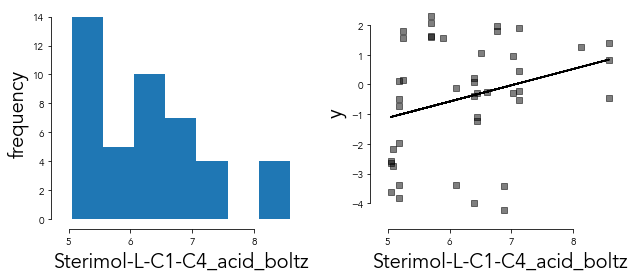

R^2 = 0.08; p-value = 0.06

-------------------------------------------------------------------------------

x22 Sterimol-B1-C1-C4_acid_boltz


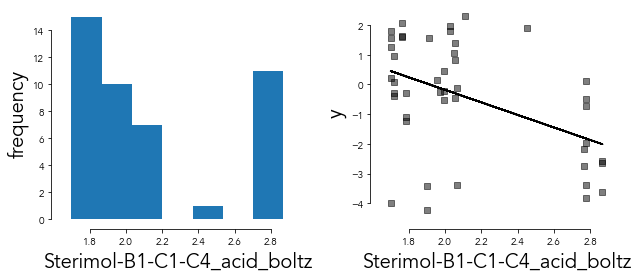

R^2 = 0.21; p-value = 1.64E-03

-------------------------------------------------------------------------------

x23 Sterimol-B5-C1-C4_acid_boltz


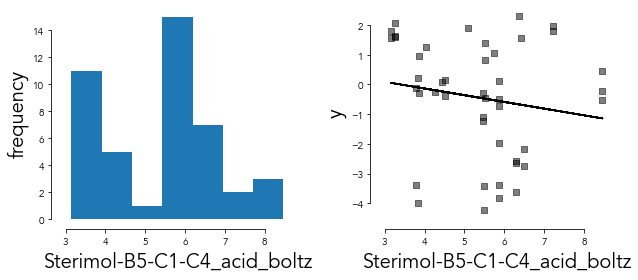

R^2 = 0.03; p-value = 0.28

-------------------------------------------------------------------------------

x24 IR-freq-C=O_acid_boltz


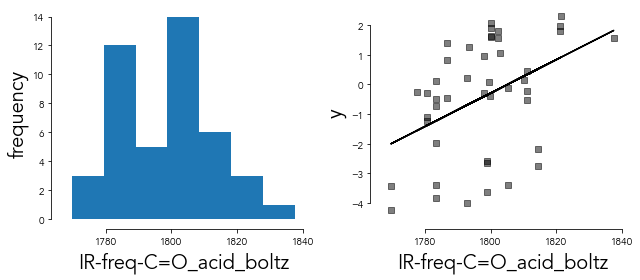

R^2 = 0.18; p-value = 4.14E-03

-------------------------------------------------------------------------------

x25 IR-freq-O-H_acid_boltz


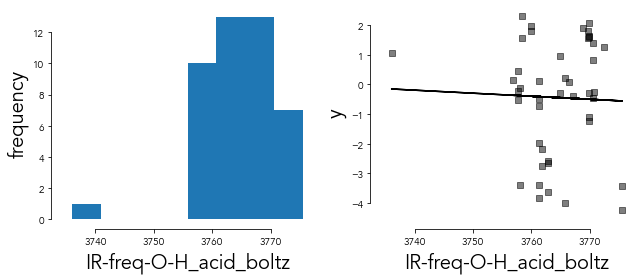

R^2 = 0.00; p-value = 0.82

-------------------------------------------------------------------------------

x26 Vbur-2.5A_acid_boltz


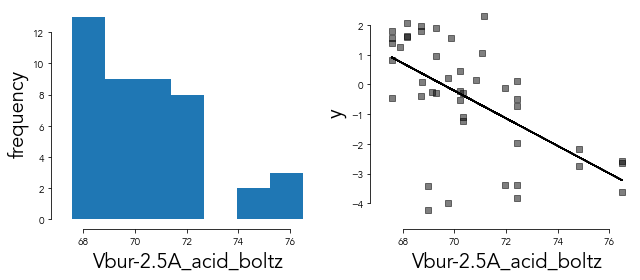

R^2 = 0.35; p-value = 2.31E-05

-------------------------------------------------------------------------------

x27 Vbur-3.0A_acid_boltz


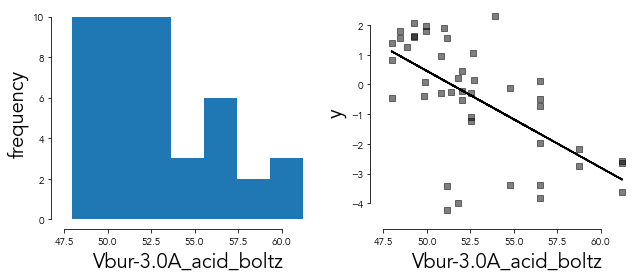

R^2 = 0.39; p-value = 6.06E-06

-------------------------------------------------------------------------------

x28 Vbur-2.0A_acid_boltz


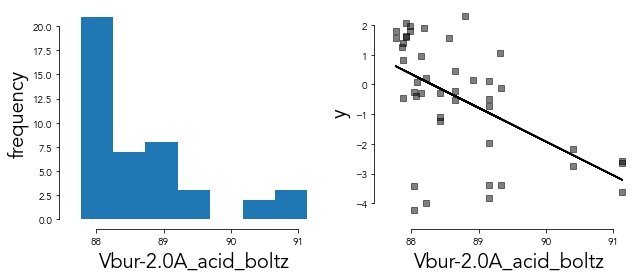

R^2 = 0.30; p-value = 1.37E-04

-------------------------------------------------------------------------------

x29 e gas_anion_boltz


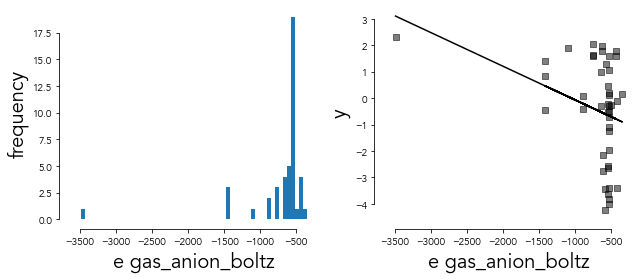

R^2 = 0.11; p-value = 0.03

-------------------------------------------------------------------------------

x30 g gas_anion_boltz


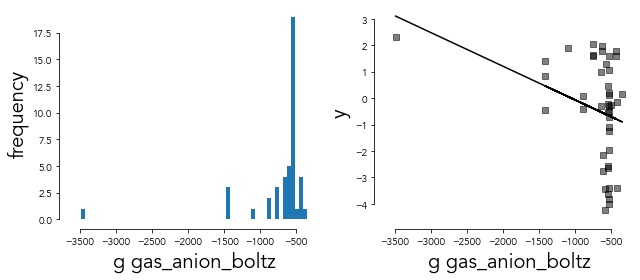

R^2 = 0.11; p-value = 0.03

-------------------------------------------------------------------------------

x31 E THF_anion_boltz


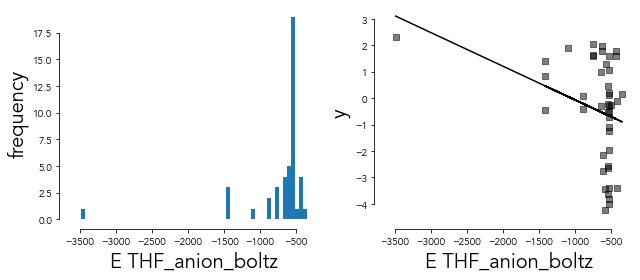

R^2 = 0.11; p-value = 0.03

-------------------------------------------------------------------------------

x32 G THF_anion_boltz


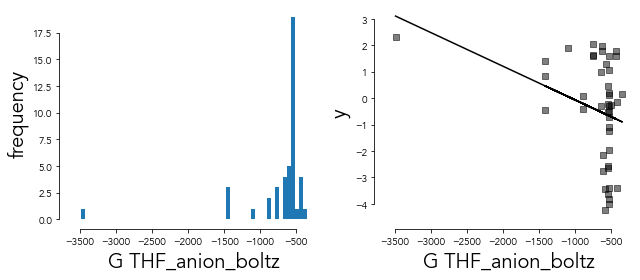

R^2 = 0.11; p-value = 0.03

-------------------------------------------------------------------------------

x33 dipole_anion_boltz


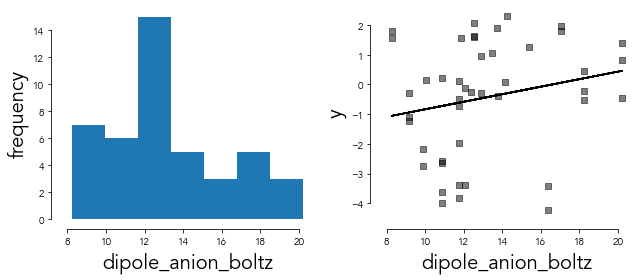

R^2 = 0.05; p-value = 0.17

-------------------------------------------------------------------------------

x34 E (HOMO)_anion_boltz


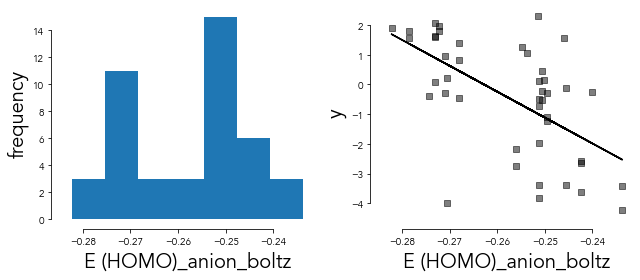

R^2 = 0.35; p-value = 2.51E-05

-------------------------------------------------------------------------------

x35 E (LUMO)_anion_boltz


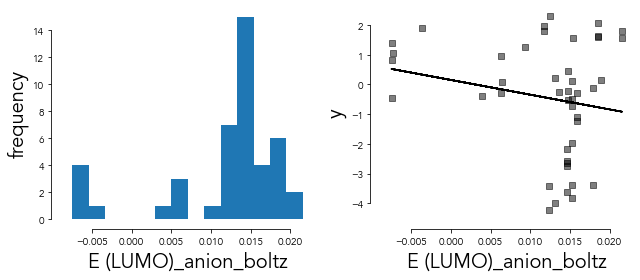

R^2 = 0.04; p-value = 0.20

-------------------------------------------------------------------------------

x36 mu_anion_boltz


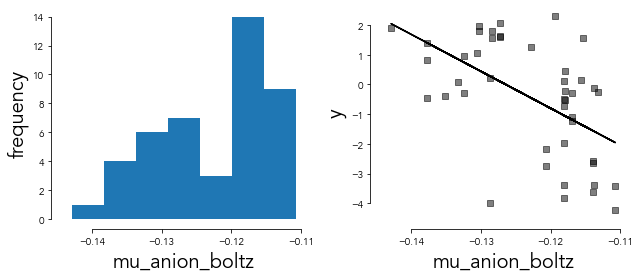

R^2 = 0.30; p-value = 1.35E-04

-------------------------------------------------------------------------------

x37 eta_anion_boltz


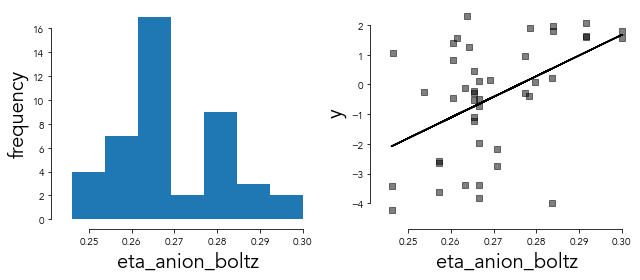

R^2 = 0.22; p-value = 1.17E-03

-------------------------------------------------------------------------------

x38 omega_anion_boltz


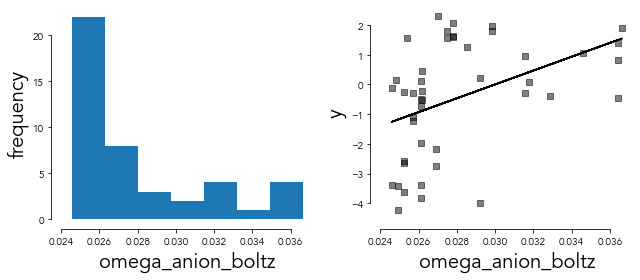

R^2 = 0.18; p-value = 3.87E-03

-------------------------------------------------------------------------------

x39 Polarizability (1)_anion_boltz


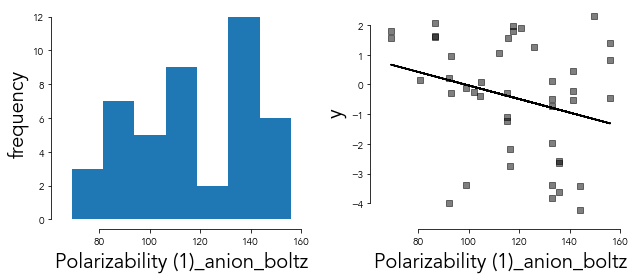

R^2 = 0.08; p-value = 0.07

-------------------------------------------------------------------------------

x40 NBO-C1 C=O_anion_boltz


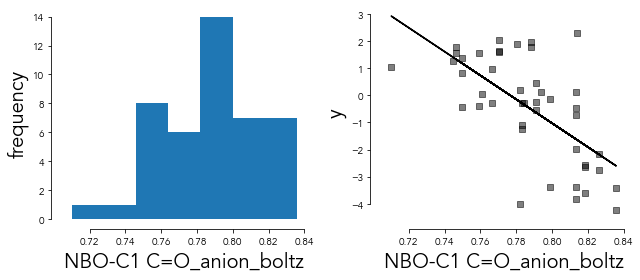

R^2 = 0.42; p-value = 1.82E-06

-------------------------------------------------------------------------------

x41 NBO-C4_anion_boltz


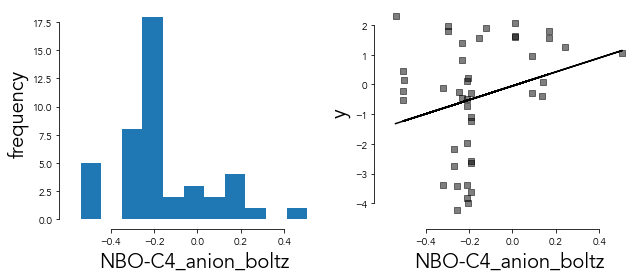

R^2 = 0.07; p-value = 0.09

-------------------------------------------------------------------------------

x42 delta_NBO-O2-O3_anion_boltz


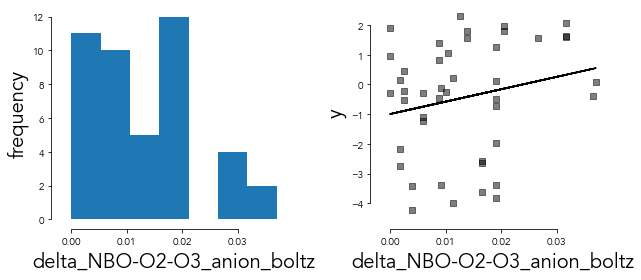

R^2 = 0.05; p-value = 0.16

-------------------------------------------------------------------------------

x43 ave_NBO-O2-O3_anion_boltz


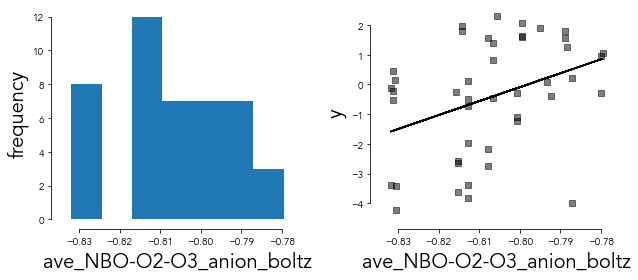

R^2 = 0.14; p-value = 0.01

-------------------------------------------------------------------------------

x44 NMR-C1 C=O_anion_boltz


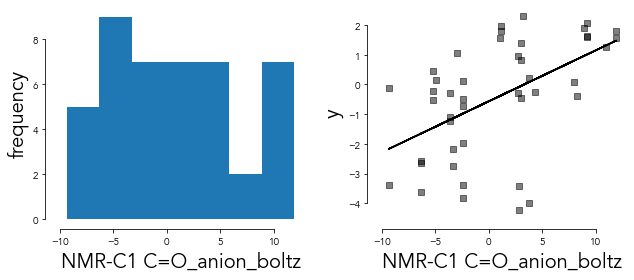

R^2 = 0.27; p-value = 3.27E-04

-------------------------------------------------------------------------------

x45 NMR-C4_anion_boltz


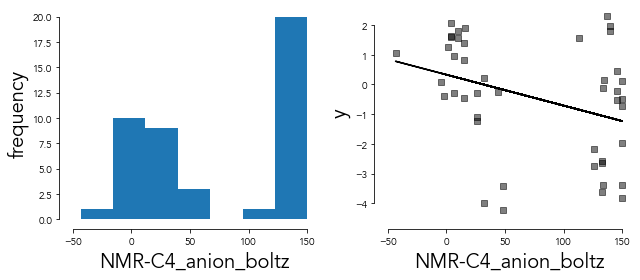

R^2 = 0.12; p-value = 0.02

-------------------------------------------------------------------------------

x46 Sterimol-L-C1-C4_anion_boltz


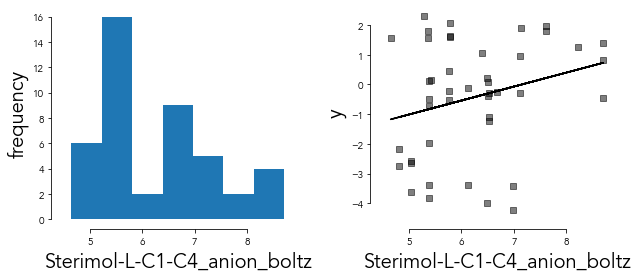

R^2 = 0.07; p-value = 0.09

-------------------------------------------------------------------------------

x47 Sterimol-B1-C1-C4_anion_boltz


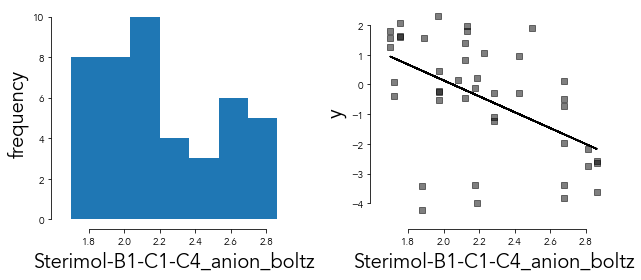

R^2 = 0.27; p-value = 3.22E-04

-------------------------------------------------------------------------------

x48 Sterimol-B5-C1-C4_anion_boltz


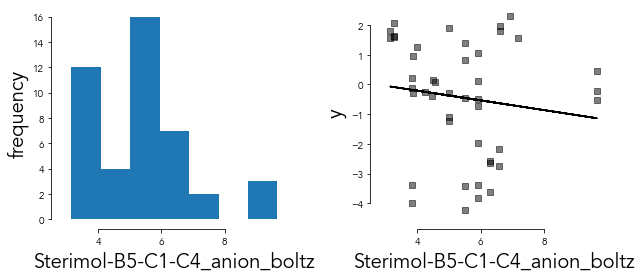

R^2 = 0.02; p-value = 0.37

-------------------------------------------------------------------------------

x49 IR-freq-CO2_asym-stretch_anion_boltz


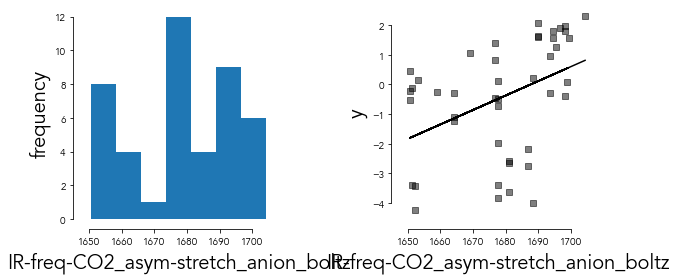

R^2 = 0.17; p-value = 4.82E-03

-------------------------------------------------------------------------------

x50 IR-freq-CO2_sym-stretch_anion_boltz


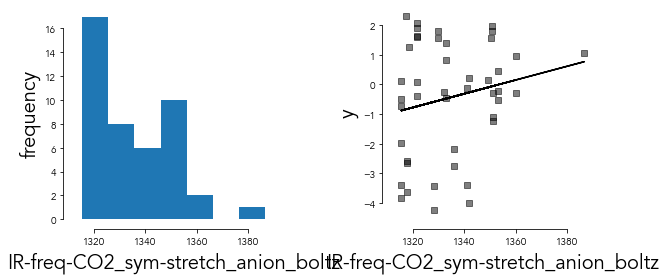

R^2 = 0.04; p-value = 0.20

-------------------------------------------------------------------------------

x51 Vbur-2.5A_anion_boltz


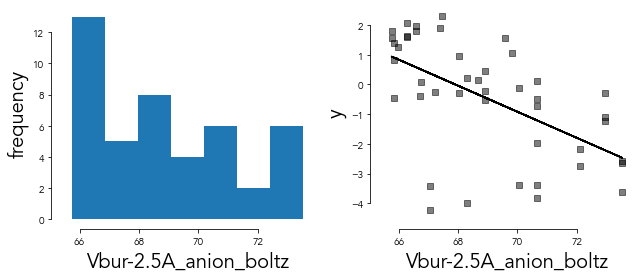

R^2 = 0.32; p-value = 5.96E-05

-------------------------------------------------------------------------------

x52 Vbur-3.0A_anion_boltz


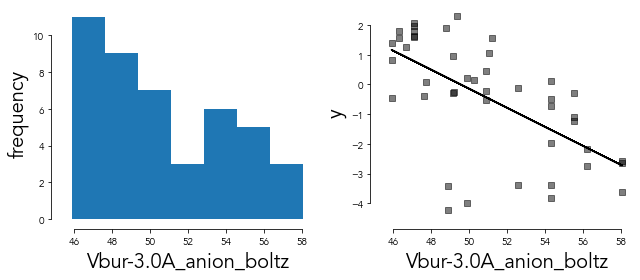

R^2 = 0.38; p-value = 7.58E-06

-------------------------------------------------------------------------------

x53 Vbur-2.0A_anion_boltz


KeyboardInterrupt: ignored

In [ ]:
# Visualize Histograms and univariate correlations for all (or selected) features
features = range(np.shape(X)[1])   # iterate over all features
#features = [3,8]

# examples for selecting features
#specify names:
# features = [x_names.index("sterimol_5-.5cB5_max")]
#specify x-numbers (1-indexed):
#features_x = ["x70","x78","x86"]
#features = [X_labels.index(i) for i in features_x]
#specify ranges (0-indexed)
#features = itertools.chain(range(15,92)) #480,2611)) #312,343)) 

for f_ind in features:
    feature = X_labels[f_ind]
    print(feature, X_names[f_ind])
    slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind], y)
    fit_line = intercept+slope*X[:,f_ind]
    
    plt.figure(figsize=(9, 4))
    
    plt.subplot(1,2,1)
    plt.hist(X[:,f_ind], bins="auto")
    plt.ylabel("frequency",fontsize=20)
    plt.xlabel(X_names[f_ind],fontsize=20)
    
    plt.subplot(1,2,2)
    plt.scatter(X[:,f_ind], y,color="black",marker="s",alpha=0.5)    
    plt.plot(X[:,f_ind],fit_line,color="black")
    plt.xlabel(X_names[f_ind],fontsize=20)
    plt.ylabel("y",fontsize=20) # "\u0394\u0394G"

#     plt.xticks(np.arange(round(min(X[:,f_ind])-0.005,3), round(max(X[:,f_ind])+0.005,3), 0.03),fontsize=15)
    plt.yticks(fontsize=15)
    sns.despine(trim=True,
            offset=10)        
    plt.tight_layout()
    plt.show()    

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n")

## Seaborn <a class="anchor" id="seaborn"></a>

x40 NBO-C1 C=O_anion_boltz


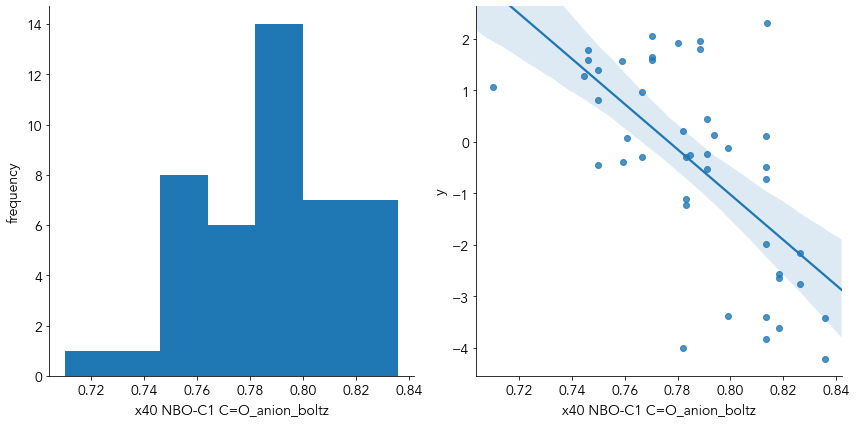

R^2 = 0.42; p-value = 1.82E-06

--------------------------------------------------------------------------------------------------------------------------



In [ ]:
# has option to only print univariate correlations if they meet an R^2 cutoff

# Use your new font on all your plots.
plt.rcParams.update({
  #"text.usetex": True,
  "font.family": "Avenir"
})

### All features:
features = range(np.shape(X)[1])

### Features by X-numbers (1-indexed):
#features_x = ["x1","x19","x20","x31","x120","x145","x160"]
#features_x = ["x2", "x3", "x4"]
#features = [X_labels.index(i) for i in features_x]

### Feature by range (0-indexed):
# features = itertools.chain(range(75,85),range(90,95))

### Set r2 cutoff
r2_cutoff = 0.4
r2_values = []

for f_ind in features:
    feature = X_labels[f_ind]
    slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind], y)
    fit_line = intercept+slope*X[:,f_ind]
    r2 = r_value**2
    r2_values.append(r2)
    if r2 >= r2_cutoff:
        print(feature, X_names[f_ind])
        plt.figure(figsize=(12, 6))
        plt.subplot(1,2,1)
        plt.hist(X[:,f_ind], bins="auto")
        plt.ylabel("frequency",fontsize=14)
        plt.xlabel(feature + " " + X_names[f_ind],fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.subplot(1,2,2)
        #sns.set_style("white")
        sns.regplot(X[:,f_ind],y,ci=95,truncate=False)
        x_max=np.max(X[:,f_ind])
        x_min=np.min(X[:,f_ind])
        y_max=np.max(y)
        y_min=np.min(y)
        delta_x = 0.05 * (x_max-x_min)
        delta_y = 0.05 * (y_max-y_min)
        plt.xlim([x_min-delta_x,x_max+delta_x])
        plt.ylim([y_min-delta_y,y_max+delta_y])
        #plt.scatter(X[:,f_ind], y,color="black",marker=".",alpha=0.5,s=150)
        #plt.plot(X[:,f_ind],fit_line,color="black")
        plt.xlabel(feature + " " + X_names[f_ind],fontsize=14)
        plt.ylabel("y",fontsize=14)  # "$ΔΔG^{≠}$"  "Yield"
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        sns.despine()
        plt.tight_layout()
        
        #toggle these two lines to either show or show and save the plots
        plt.show()
        #plt.savefig("plotname.png",dpi=300)
        
        if p_value > 0.01:
            print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
        else:
            print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
        print("\n--------------------------------------------------------------------------------------------------------------------------\n")

## Plot Feature vs Feature <a class="anchor" id="2feature"></a>

x44 NMR-C1 C=O_anion_boltz
x28 Vbur-2.0A_acid_boltz

44 samples
R^2 = 0.50;             p-value = 8.17E-08


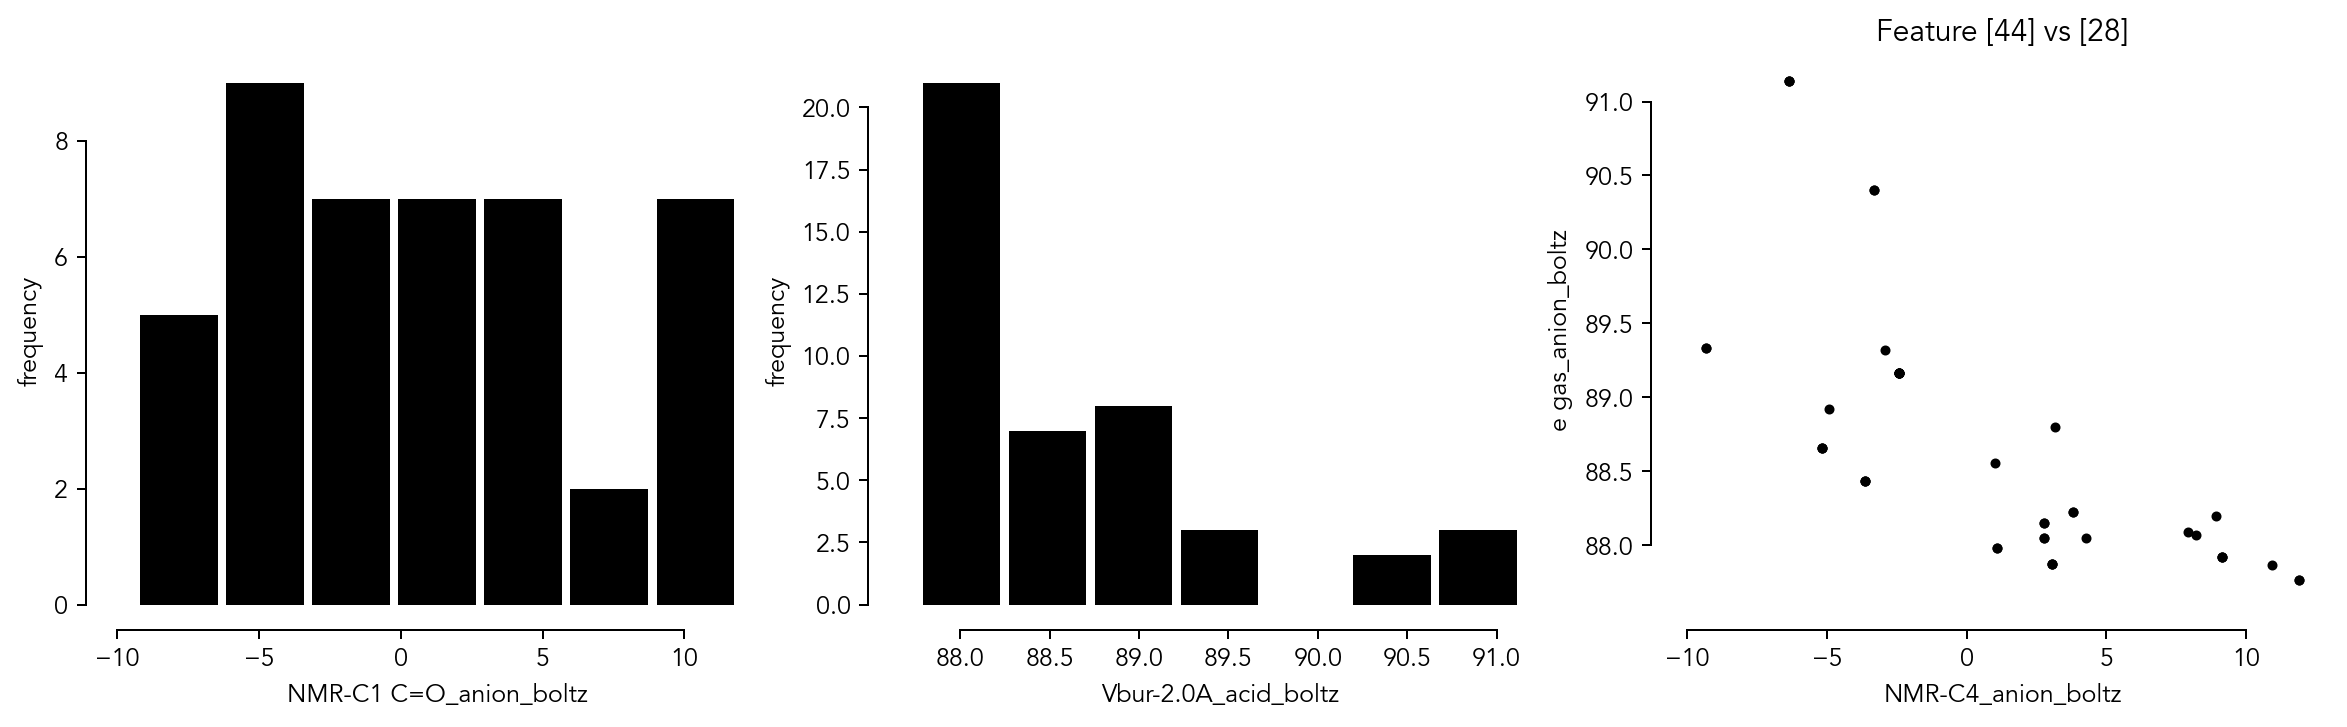

In [20]:
#feats_to_check1 = range(1,num_par+1) 
#itertools.chain(range(8,15),range(35,40)) #this would be 20-29,35-39
#feats_to_check2 = range(1,num_par+1) 
#itertools.chain(range(15,25),range(35,40))

feats_to_check1 = [44]
feats_to_check2 = [28]

for i in feats_to_check1:
    num1 = i
    x_format1 = "x{}".format(num1)
    if type(x_format1) == str:
            [x_format1] = [X_labels.index(i) for i in [x_format1]]
    for p in feats_to_check2:
        num2 = p
        x_format2 = "x{}".format(num2)
        
        #---
        if type(x_format2) == str:
            [x_format2] = [X_labels.index(i) for i in [x_format2]]
        #print(i,x_format1,type(x_format1))
        #print(p,x_format2,type(x_format2))

        if x_format1 != x_format2:
            
            slope, intercept, 
            r_value, p_value, 
            std_err = stats.linregress(X[:,x_format1],X[:,x_format2])
            fit_line = intercept+slope*X[:,x_format1]
            
            print(X_labels[x_format1], X_names[x_format1])
            print(X_labels[x_format2], X_names[x_format2])
            print("\n{} samples".format(np.shape(X[:,x_format1])[0]))
            print("R^2 = {:.2f}; \
            p-value = {:.2E}".format(r_value**2,p_value))

            plt.figure(figsize=(13, 4), dpi = 180)

            plt.subplot(1,3,1)
            plt.hist(X[:,x_format1], bins="auto",
                     color="black",
                     rwidth=0.9)
            plt.ylabel("frequency")
            plt.xlabel(X_names[x_format1])
            plt.subplot(1,3,2)
            plt.hist(X[:,x_format2], bins="auto",
                     color="black", 
                     rwidth=0.9)
            plt.ylabel("frequency")
            plt.xlabel(X_names[x_format2])

            plt.subplot(1,3,3)
            plt.scatter(X[:,x_format1], X[:,x_format2],
                        color="black",marker=".")    
            #plt.plot(X[:,f_ind_1],fit_line)

            # label by x number
            #plt.xlabel(X_labels[num1])
            #plt.ylabel(X_labels[num2])
            # label by x name           
            plt.xlabel(X_names[num1])
            plt.ylabel(X_names[num2])
            plt.title(f'Feature {feats_to_check1} vs {feats_to_check2}')
            plt.tight_layout()
            sns.despine(trim=True, offset=10)
            plt.savefig(f'Feature {feats_to_check1} vs {feats_to_check2}.svg')
            plt.show()    

## Correlation Map <a class="anchor" id="corr_map"></a>

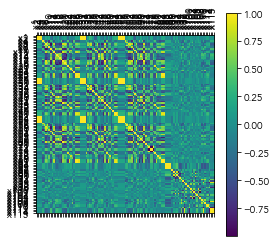

In [ ]:
#%matplotlib notebook
# this will open an interactive plot that you can enlarge and zoom into

corrmap = np.corrcoef(X.T)
plt.matshow(corrmap)
plt.xticks(range(len(X_labels)),X_labels, fontsize=10, rotation=90)
plt.yticks(range(len(X_labels)),X_labels, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

# Remove Colinear Descriptors <a class="anchor" id="colinear"></a>

## Identify Only <a class="anchor" id="ident_colinear"></a>

In [ ]:
#feats_to_check1 = range(1,num_par+1) #itertools.chain(range(8,15),range(35,40)) #this would be 20-29,35-39
#feats_to_check2 = range(1,num_par+1) #itertools.chain(range(15,25),range(35,40))

feats_to_check1 = 1,25,105,118
feats_to_check2 = 5,7,106,118

colinear_cutoff = 0.95
colinear_feats = []

for i in feats_to_check1:
    num1 = i
    x_format1 = "x{}".format(num1)
    if x_format1 not in X_labels:
        x_format1 = "s{}".format(num1)
    
    if type(x_format1) == str:
            [x_format1] = [X_labels.index(i) for i in [x_format1]]
    for p in feats_to_check2:
        num2 = p
        
        x_format2 = "x{}".format(num2)
        if x_format2 not in X_labels:
            x_format2 = "s{}".format(num2)
        
        #---
        if type(x_format2) == str:
            [x_format2] = [X_labels.index(i) for i in [x_format2]]

        if x_format1 != x_format2:
            slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,x_format1],X[:,x_format2])
            fit_line = intercept+slope*X[:,x_format1]
            
            if (r_value**2) >= colinear_cutoff:
                colinear_feats.append((X_labels[x_format1],X_names[x_format1],' : ',X_labels[x_format2],X_names[x_format2]))
                
print('')
print('Number of Colinear Pairs: ',str(len(colinear_feats)))
print('')
for c in colinear_feats:
    print(' '.join(list(c)))


Number of Colinear Pairs:  0



## Automatically Remove <a class="anchor" id="auto_colinear"></a>

In [ ]:
# automatically removes colinear descriptor w/ HIGHER xLabel number
# ex: x1,x8 are colinear, removes x8

feats_to_check1 = range(1,num_par+1) #itertools.chain(range(8,15),range(35,40)) #this would be 20-29,35-39
feats_to_check2 = range(1,num_par+1) #itertools.chain(range(15,25),range(35,40))

colinear_cutoff = 0.95
removed_feats = []
removed_feats_verbose = []

for i in feats_to_check1:
    num1 = i
    x_format1 = "x{}".format(num1)
    if type(x_format1) == str:
            [x_format1] = [X_labels.index(i) for i in [x_format1]]
    for p in feats_to_check2:
        num2 = p
        x_format2 = "x{}".format(num2)
        
        #---
        if type(x_format2) == str:
            [x_format2] = [X_labels.index(i) for i in [x_format2]]

        if x_format1 != x_format2:
            slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,x_format1],X[:,x_format2])
            fit_line = intercept+slope*X[:,x_format1]
            
            if (r_value**2) >= colinear_cutoff:
                if x_format1 > x_format2:
                    if X_labels[x_format1] not in removed_feats:
                        removed_feats.append(X_labels[x_format1])
                        removed_feats_verbose.append((X_labels[x_format1],' : ',X_names[x_format1]))
                elif x_format2 > x_format1:
                    if X_labels[x_format2] not in removed_feats:
                        removed_feats.append(X_labels[x_format2])
                        removed_feats_verbose.append((X_labels[x_format2],' : ',X_names[x_format2]))

print('')
print(str(len(removed_feats)),' Colinear Features Removed:') 
print('')
for feat in removed_feats_verbose:
    print(' '.join(feat))

ValueError: ignored

## Manually Remove <a class="anchor" id="manual_colinear"></a>

In [ ]:
# NOTE: Run Identify Only section first, then this one

def check_input(feat):

    if feat.lower() == pair[0] or 'x'+feat == pair[0]:
        removed_feats.append(pair[3])
        print('Keeping ',feat)
    elif feat.lower() == pair[3] or 'x'+feat == pair[3]:
        removed_feats.append(pair[0])
        print('Keeping ',feat)
    elif feat.lower() == 'both':
        print('Keeping ',feat)
    else:
        print('ERR: Type either '+pair[0]+', '+pair[3]+', or both')
        feat = input('   Keep '+pair[0]+' ( '+pair[1]+' ) OR '+pair[3]+' ( '+pair[4]+' ) OR both: ')
        check_input(feat)

#removed_feats = ['x2','x5','']
removed_feats = []

for pair in colinear_feats:
    if pair[0] not in removed_feats and pair[3] not in removed_feats:
        feat = input('Keep '+pair[0]+' ( '+pair[1]+' ) OR '+pair[3]+' ( '+pair[4]+' ) OR both: ')
        check_input(feat)

print('')
print('DONE')
print('')
print(str(len(removed_feats)),' Colinear Features Removed:') 
print('')
print(' '.join(removed_feats))

NameError: ignored

# Thresholds <a class="anchor" id="thresh"></a>

## Single-Node Regression <a class="anchor" id="single_node"></a>

Accuracy: 0.26
(array([43], dtype=int64),)
43
x44 prox6_ESA WSD


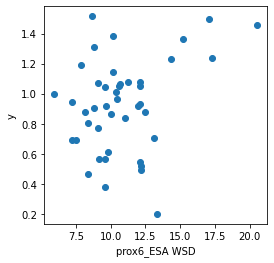

In [ ]:
# import graphviz 

dt = DecisionTreeRegressor(max_depth=1).fit(X, y) #max_depth=1
print("Accuracy: {:.2f}".format(dt.score(X, y)))

print(np.where(dt.feature_importances_ != 0))

#feat = int(np.where(dt.feature_importances_ != 0)[0])
feat = list(np.where(dt.feature_importances_ != 0)[0])

for f in feat:
    print(f)
    print(X_labels[int(f)],X_names[int(f)])

    plt.figure(figsize=(4, 4))
    plt.scatter(X[:,int(f)], y)    
    plt.xlabel(X_names[int(f)])
    plt.ylabel("y")  # "$ΔΔG^{≠}$"  "Yield"

# dot_data = tree.export_graphviz(dt, out_file=None, 
#                      feature_names=X_names,   
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph  
    plt.show()

## Classify Highest and Lowest Group <a class="anchor" id="classify_group"></a>

x61 Nprobe  rMIN
x114 p7 ESA WSD%


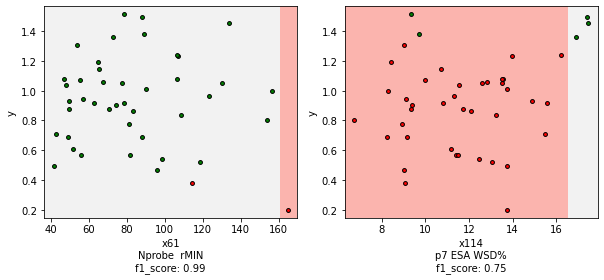

In [ ]:
# find features that separate the group with highest/lowest output y
# change the definition of bins in the histogram to get control over how these groups are defined
y_hist,y_bin_edges = np.histogram(y,bins="auto")
y_class_low = [0 if i < y_bin_edges[1] else 1 for i in y]
y_class_high = [1 if i > y_bin_edges[-2] else 0 for i in y]

plt.figure(figsize=(8.5, 4))
n_classes = 2
plot_colors = "rg"
plot_step = 0.02
y_classes = [np.asarray(y_class_low),np.asarray(y_class_high)]
for y_class,i in zip(y_classes,[1,2]):
    dt = DecisionTreeClassifier(max_depth=1).fit(X, y_class)
    feat = int(np.where(dt.feature_importances_ != 0)[0])    
    a = ("f1_score: {:.2f}".format(metrics.f1_score(y_class,dt.predict(X))))
#    b = ("auc: {:.2f}".format(metrics.roc_auc_score(y_class,dt.predict(X))))
    print(X_labels[feat],X_names[feat])    
    xpltlabel = X_labels[feat] + "\n" + X_names[feat] + "\n" + a# + "\n" + b

    dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,feat].reshape(-1, 1), y_class)
    x_min, x_max = X[:, feat].min(), X[:, feat].max()
    y_min, y_max = y.min(), y.max()
    dx,dy = x_max-x_min,y_max-y_min
    xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
    
    plt.subplot(1,2,i)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)

    plt.xlabel(xpltlabel)
    plt.ylabel("y")

    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_class == i)
        plt.scatter(X[idx, feat], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.tight_layout()

# dot_data = tree.export_graphviz(dt_plt, out_file=None, 
#                      feature_names=[x_names[feat]],   
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph

## Classify by Value <a class="anchor" id="classify_val"></a>

x107 HBONDS intact
Decision threshold = 0.65
Accuracy: 0.74
f1_score: 0.56
N = 43


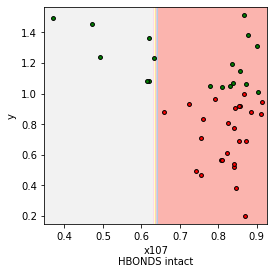

In [ ]:
# divide samples into two classes based on y_cut, find the feature that most clearly distinguishes these groups
#y_cut = 50
y_cut = 1

#this can be done on a subset of features
# features = [i for i in itertools.chain(range(75,85),range(90,95))]
# features = [i for i in range(38,135)]
features = range(np.shape(X)[1])
X_use = X[:,features]

y_class = np.array([0 if i < y_cut else 1 for i in y])
n_classes=2
dt = DecisionTreeClassifier(max_depth=1).fit(X_use, y_class)

feat = features[int(np.where(dt.feature_importances_ != 0)[0])]
print(X_labels[feat],X_names[feat])

dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,feat].reshape(-1, 1), y_class)
print("Decision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nN = {}".format(
        dt_plt.tree_.threshold[0],
        dt_plt.score(X[:,feat].reshape(-1, 1), y_class),
        metrics.f1_score(y_class,dt_plt.predict(X[:,feat].reshape(-1, 1))),
        len(y)
    ))

plot_colors = "rg"
plot_step = 0.02
x_min, x_max = X[:,feat].min(), X[:,feat].max()
y_min, y_max = y.min(), y.max()
dx,dy = x_max-x_min,y_max-y_min
xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                     np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))

plt.figure(figsize=(4, 4))    
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)
xpltlabel = X_labels[feat] + "\n" + X_names[feat]

plt.xlabel(xpltlabel)
plt.ylabel("y")  # "$ΔΔG^{≠}$"  "Yield"

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_class == i)
    plt.scatter(X[idx, feat], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)    

plt.show()

## Property Threshold <a class="anchor" id="prop_thresh"></a>

x2 Rh NBO avg
Decision threshold = 0.67
Accuracy: 0.56
f1_score: 0.65
N = 43


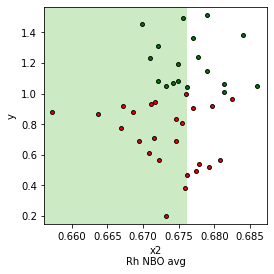


----------------------------------------------

x3 RhRh BD
Decision threshold = -0.23
Accuracy: 0.51
f1_score: 0.63
N = 43


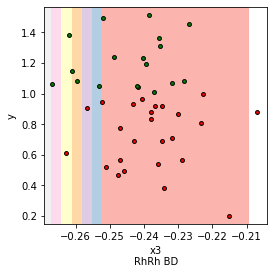


----------------------------------------------

x4 RhRh BD*
Decision threshold = 0.92
Accuracy: 0.44
f1_score: 0.60
N = 43


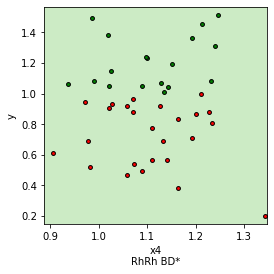


----------------------------------------------

x5 RhRh dE
Decision threshold = 1.20
Accuracy: 0.44
f1_score: 0.60
N = 43


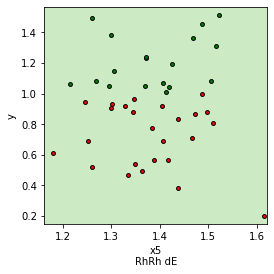


----------------------------------------------

x6 Rh dpi_avg
Decision threshold = -0.27
Accuracy: 0.49
f1_score: 0.62
N = 43


TypeError: Input z must be at least a (2, 2) shaped array, but has shape (72, 1)

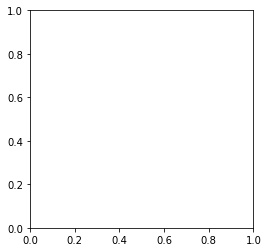

In [ ]:
# divide samples into two classes based on y_cut, visualize how features separate these classes
#y_cut = 50
y_cut = 1
class_weight = {0:1,1:20}

#select features here
features = range(len(X_labels))   # iterate over all features
features = itertools.chain(range(1,10))
#features = itertools.chain(range(7,20))

y_class = np.array([0 if i < y_cut else 1 for i in y])
n_classes = 2
plot_colors = "rg"
plot_step = 0.02 #0.002

for f_ind in features:
    feature = X_labels[f_ind]
    print(feature, X_names[f_ind])
    dt = DecisionTreeClassifier(max_depth=1,class_weight=class_weight).fit(X[:,f_ind].reshape(-1, 1), y_class)
    print("Decision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nN = {}".format(
        dt.tree_.threshold[0],
        dt.score(X[:,f_ind].reshape(-1, 1), y_class),
        metrics.f1_score(y_class,dt.predict(X[:,f_ind].reshape(-1, 1))),
        len(y)
    ))
    
    dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,f_ind].reshape(-1, 1), y_class)
    x_min, x_max = X[:,f_ind].min(), X[:,f_ind].max()
    y_min, y_max = y.min(), y.max()
    dx,dy = x_max-x_min,y_max-y_min
    xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
    
    plt.figure(figsize=(4, 4))    
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)
    xpltlabel = X_labels[f_ind] + "\n" + X_names[f_ind]

    plt.xlabel(xpltlabel)
    plt.ylabel("y")  # "$ΔΔG^{≠}$"  "Yield"

    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_class == i)
        plt.scatter(X[idx, f_ind], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)    
    
    #plt.savefig(name,dpi=300,bbox_inches = 'tight')

    plt.show()
    print("\n----------------------------------------------\n")

# Data Preparation <a class="anchor" id="prep"></a>

## Manual Preselection <a class="anchor" id="presel"></a>

In [ ]:
# preselection option 1
# comment-out first line in Train/test split if using this

# remove samples based on a feature-value 
#select_feature = "x8" 

# define cutoff 
mask_prop = X[:,X_labels.index(select_feature)]<5.62   

X_sel,y_sel,y_labels_sel = X[mask_prop],y[mask_prop],y_labels[mask_prop]
print("Shape X: {}".format(X_sel.shape))
print("Shape y: {}".format(y_sel.shape)) 
print("Shape labels: {}".format(y_labels_sel.shape)) 

NameError: name 'select_feature' is not defined

In [ ]:
# preselection
# comment-out first line in Train/test split if using this

# remove samples based on index (0-indexed)

#exclude = [i for i in range(84,96)] #+[i for i in range(26,37)]

# withhold cyclopropyl + napthyl
#exclude = [43,44,45,46,47,48,49,50,51,52,53,73,74,75,76,77,78,79,80,81,82,83,84]
# withhold nbutyl + napthyl + PMB
#exclude = [21,22,23,24,25,26,27,28,29,30,31,73,74,75,76,77,78,79,80,81,82,83,84,0,1,2,3,4]

# withhold Lucas' cats
#exclude = [5,6,7,8,21,22,23,24,32,33,34,35,43,44,45,46,54,55,56,57,63,64,65,66,73,74,75,76]

# Du Bois OFace
exclude = []
#exclude = [0]

print(exclude)
mask = [i for i in range(len(y)) if i not in exclude]
X_sel,y_sel,y_labels_sel = X[mask],y[mask],y_labels[mask]

[]


## Training/Test Split <a class="anchor" id="split"></a>

TS: [43, 26, 33, 30, 24, 9, 40, 38, 36, 4, 6, 42, 35, 16, 2, 32, 29, 31, 21, 25, 37, 22, 39, 19, 1, 23, 11, 41, 7, 5, 13]
VS: [0, 3, 8, 10, 12, 14, 15, 17, 18, 20, 27, 28, 34]
['Ac13-N16', 'Ac5-N6', 'Ac5-N2', 'Ac17-N6', 'Ac5-N15', 'Ac17-N2', 'Ac1-N10', 'Ac15-N5', 'Ac20-N11', 'Ac4-N2', 'Ac9-N6', 'Ac1-N6', 'Ac10-N11']
y_mean TS: -0.135
y_mean VS: -1.164
Shape X_train: (31, 115)
Shape X_test:  (13, 115)


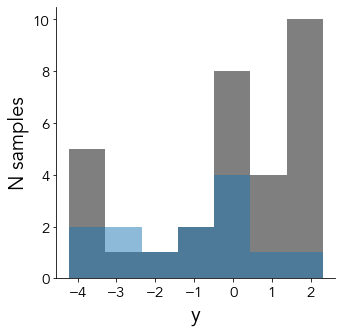

In [37]:
#X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

# select method of split:
# random
# y_equidist - picks points that evenly span the output variable y. 
#              Normally doesn't pick highest/lowest values but this can be activated by changing the variable no_extrapolation in the respective section
# ks - Kennard Stone algorithm picks points based on an even distriution in feature space
# define - give a list of sample indices for either VS or TS in the corresponding code section 
# none - all samples in TS

# the numbers in the variables VS and TS refer to the original 0-indexed sample numbers 

#split = "y_equidist" # test set based on y output equidistant
split = "ks" #kennard stone based on param values
#split = "define"
#split = 'none' # for use with manual preselection
#split = 'random'

test_ratio = 0.28 #0.2 or higher

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y_sel, 
        random_state=randomstate+47, 
        test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "define":
   # numbers according to sample lines in the excel sheet (that is, including indexes of 'excluded' samples)
    # for defining the TS, change the names of TS and VS in the next three lines
    #TS = [16,27,25,5,13,9,29,7]
    VS = [i for i in range(84,96)] #all_w_substrates
    TS = [i for i in range(X.shape[0]) if i not in VS and i not in exclude]

    X_train,y_train,X_test,y_test = X_sel[TS],y_sel[TS],X_sel[VS],y_sel[VS]
    
elif split == "ks":
    import kennardstonealgorithm as ks
    TS,VS = ks.kennardstonealgorithm(X_sel,int((1-test_ratio)*np.shape(X_sel)[0]))
    X_train, y_train,X_test, y_test = X_sel[TS], y_sel[TS],X_sel[VS], y_sel[VS]
  
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]   

elif split == "y_equidist":
    no_extrapolation = True
    
    import kennardstonealgorithm as ks
    if no_extrapolation:
        minmax = [np.argmin(y_sel),np.argmax(y_sel)]
        y_ks = np.array(([i for i in y_sel if i not in [np.min(y_sel),np.max(y_sel)]]))
        y_ks_indices = [i for i in range(len(y_sel)) if i not in minmax]
        
        # indices relative to y_ks:
        VS_ks,TS_ks = ks.kennardstonealgorithm(y_ks.reshape(np.shape(y_ks)[0],1),int((test_ratio)*(2+np.shape(y_ks)[0])))
        # indices relative to y_sel:
        TS_ = sorted([y_ks_indices[i] for i in list(TS_ks)]+minmax)
        VS_ = sorted([y_ks_indices[i] for i in VS_ks])

    else:
        VS_,TS_ = ks.kennardstonealgorithm(y_sel.reshape(np.shape(y_sel)[0],1),int((test_ratio)*np.shape(y_sel)[0]))
    
    X_train, y_train,X_test, y_test = X_sel[TS_], y_sel[TS_],X_sel[VS_], y_sel[VS_]
    
    # indices relative to y
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]

elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude], exclude
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
#else: 
#    raise ValueError("split option not recognized")

print("TS: {}".format(TS))
print("VS: {}".format(VS))
print([y_labels[i] for i in VS])
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(5, 5))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
# plt.legend(loc='best')
plt.xlabel("y",fontsize=20)
plt.ylabel("N samples",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()
plt.show()

## Scaling <a class="anchor" id="scale"></a>

In [38]:
# scale features by mean/variance, pick the relevant option (normally: StandardScaler)

scaler = StandardScaler()
#scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X_all)

#print(len(X_test_sc))

Accuracy: 0.44
(array([48]),)
48
x49 IR-freq-CO2_asym-stretch_anion_boltz


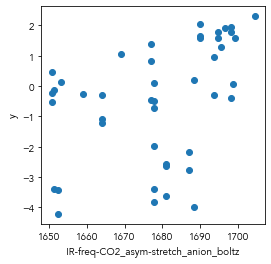

In [39]:
# import graphviz 

#dt = DecisionTreeRegressor(max_depth=5).fit(X_all_sc, y)
dt = DecisionTreeRegressor(max_depth=1).fit(X_all_sc, y)
print("Accuracy: {:.2f}".format(dt.score(X_all_sc, y)))

print(np.where(dt.feature_importances_ != 0))

#feat = int(np.where(dt.feature_importances_ != 0)[0])
feat = list(np.where(dt.feature_importances_ != 0)[0])

for f in feat:
    print(f)
    print(X_labels[int(f)],X_names[int(f)])

    plt.figure(figsize=(4, 4))
    plt.scatter(X[:,int(f)], y)    
    plt.xlabel(X_names[int(f)])
    plt.ylabel("y")  # "$ΔΔG^{≠}$"  "Yield"

# dot_data = tree.export_graphviz(dt, out_file=None, 
#                      feature_names=X_names,   
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph  
    plt.show()

Feature: x14, Score: 0.05115
Feature: x15, Score: 0.00016
Feature: x17, Score: 0.00001
Feature: x24, Score: 0.00156
Feature: x27, Score: 0.00079
Feature: x38, Score: 0.00018
Feature: x40, Score: 0.19137
Feature: x42, Score: 0.00001
Feature: x49, Score: 0.43610
Feature: x51, Score: 0.00031
Feature: x54, Score: 0.06875
Feature: x58, Score: 0.00017
Feature: x59, Score: 0.01935
Feature: x60, Score: 0.00010
Feature: x72, Score: 0.00070
Feature: x78, Score: 0.00098
Feature: x88, Score: 0.00217
Feature: x89, Score: 0.07874
Feature: x91, Score: 0.00025
Feature: x92, Score: 0.00017
Feature: x93, Score: 0.02526
Feature: x97, Score: 0.00877
Feature: x99, Score: 0.00001
Feature: x101, Score: 0.00008
Feature: x102, Score: 0.00086
Feature: x103, Score: 0.00296
Feature: x112, Score: 0.00058
Feature: x113, Score: 0.00005
Feature: x114, Score: 0.01693
Feature: x115, Score: 0.09151


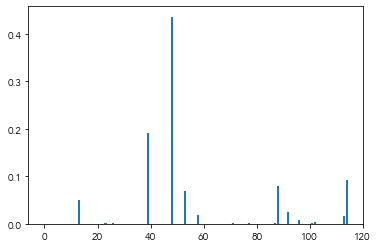

In [40]:
# feature importance scores

from matplotlib import pyplot
model = DecisionTreeRegressor()
# fit the model
model.fit(X_all_sc, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    if v != 0.000:
        print('Feature: x%0d, Score: %.5f' % (i+1,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: x1, Score: 0.00555
Feature: x2, Score: 0.00550
Feature: x3, Score: 0.00554
Feature: x4, Score: 0.00549
Feature: x5, Score: -0.51641
Feature: x6, Score: -0.07786
Feature: x7, Score: -0.17629
Feature: x8, Score: -0.17142
Feature: x9, Score: -0.05538
Feature: x10, Score: 0.19033
Feature: x11, Score: 0.00925
Feature: x12, Score: -0.05422
Feature: x13, Score: 0.02681
Feature: x14, Score: 0.30357
Feature: x15, Score: -0.11929
Feature: x16, Score: -0.36212
Feature: x17, Score: -0.10201
Feature: x18, Score: -0.03729
Feature: x19, Score: -0.26121
Feature: x20, Score: -0.15986
Feature: x21, Score: 0.20447
Feature: x22, Score: -0.10931
Feature: x23, Score: -0.19668
Feature: x24, Score: 0.34036
Feature: x25, Score: 0.09524
Feature: x26, Score: -0.32649
Feature: x27, Score: -0.39464
Feature: x28, Score: -0.34292
Feature: x29, Score: 0.00556
Feature: x30, Score: 0.00550
Feature: x31, Score: 0.00554
Feature: x32, Score: 0.00549
Feature: x33, Score: 0.23688
Feature: x34, Score: 0.07409
Featur

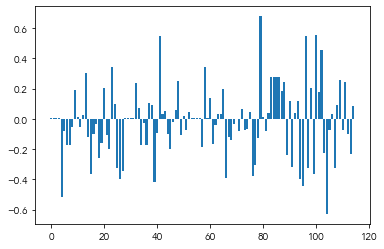

In [41]:
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

# define the model
model = LinearRegression()
# fit the model
model.fit(X_all_sc, y)

# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
    if v != 0.000:
        print('Feature: x%0d, Score: %.5f' % (i+1,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Add Cross-Terms <a class="anchor" id="crosst"></a>

**Don't run this for multivariate model search**

In [ ]:
# Add polynomial features/interaction terms
# this is not yet implemented properly in some sections. 
# for 5.1-manual selection: specify cross-term with space between the components: x1 x40 + x6
# Essentially only section 5.2 can use cross-terms so far
# don't run this twice
# rerun scaling after this...

# skip first, can be difficult to interpret (easy to overfit)

polyfeats = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
X_train_p = polyfeats.fit_transform(X_train_sc)  #[:,[1,8,0]])
X_test_p = polyfeats.transform(X_test_sc)
X_all_p = polyfeats.transform(X_all_sc)

def add_to_x(matchobj):
    if "^" in matchobj.group(0):
        n = int(matchobj.group(0).split("^")[0])+1
        return("{} x{}".format(n,n))
    else:
        return(str(int(matchobj.group(0))+1))
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])

In [ ]:
# filter out non-significant crossterms based on p-value with target variable
p_val_cutoff = 0.005

r2s = []
pvals = []
for f_ind,feature in enumerate(X_train_p.T):
    slope, intercept, r_value, p_value, std_err = stats.linregress(feature, y_train)    
    r2s.append(r_value**2)
    pvals.append(p_value)
    
r2s_ = np.asarray(r2s)
pvals_ = np.asarray(pvals)

keep_p_ = [i[0] for i in np.argwhere(pvals_<p_val_cutoff) if i not in range(np.shape(X_all)[1])]
keep_p = [i for i in range(np.shape(X_all)[1])] + keep_p_

def sub_label_to_name(matchobj):
    return(X_labelname_dict[matchobj.group(0)])
def sub_labelname(matchobj):
    return(matchobj.group(0)+" "+X_labelname_dict[matchobj.group(0)])
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])
X_p_labels = list(np.reshape(pfnames[keep_p],len(keep_p)))
X_p_names = [re.sub("x[0-9]+",sub_label_to_name,st) for st in X_p_labels]
X_p_labelname = [re.sub("x[0-9]+",sub_labelname,st) for st in X_p_labels]

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train_p[:,keep_p])
X_test_sc = scaler.transform(X_test_p[:,keep_p])
X_all_sc = scaler.transform(X_all_p[:,keep_p])

X_labels = X_p_labels
X_names = X_p_names
X_labelname = X_p_labelname

print(X_labels)

print("{} cross-terms with p-value < {}".format(len(keep_p_),p_val_cutoff))

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108', 'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x5 x5', 'x5 x9', 'x5 x22', 'x5 x26', 'x5 x28', 'x5 x83', 'x6 x24', 'x6 x109', 'x8 x24', 'x8 x25', 'x8 x94', 'x8 x109', 'x11 x101', 'x13 x94', 'x19 x40', 'x24 x101', 'x25 x59', 'x25 x61',

# Linear Modeling <a class="anchor" id="linear"></a>

## Manual Model Selection <a class="anchor" id="linear_manual"></a>


Split method: ks
Test ratio: 0.28

Features: x40 + x44 + x80 + x108

Parameters:
   -0.1351 + 
   -1.0875 * x40 NBO-C1 C=O_anion_boltz
    1.0929 * x44 NMR-C1 C=O_anion_boltz
    0.8858 * x80 IR-freq-C=O_interm_boltz
   -1.0286 * x108 Sterimol-B1-N1-C4_amine_boltz

Training R2  = 0.795
Training Q2  = 0.695
Training MAE = 0.740
Training 4-fold R2 = 0.676 (+/- 0.002)

Test R2      = 0.852
Test MAE     = 0.580


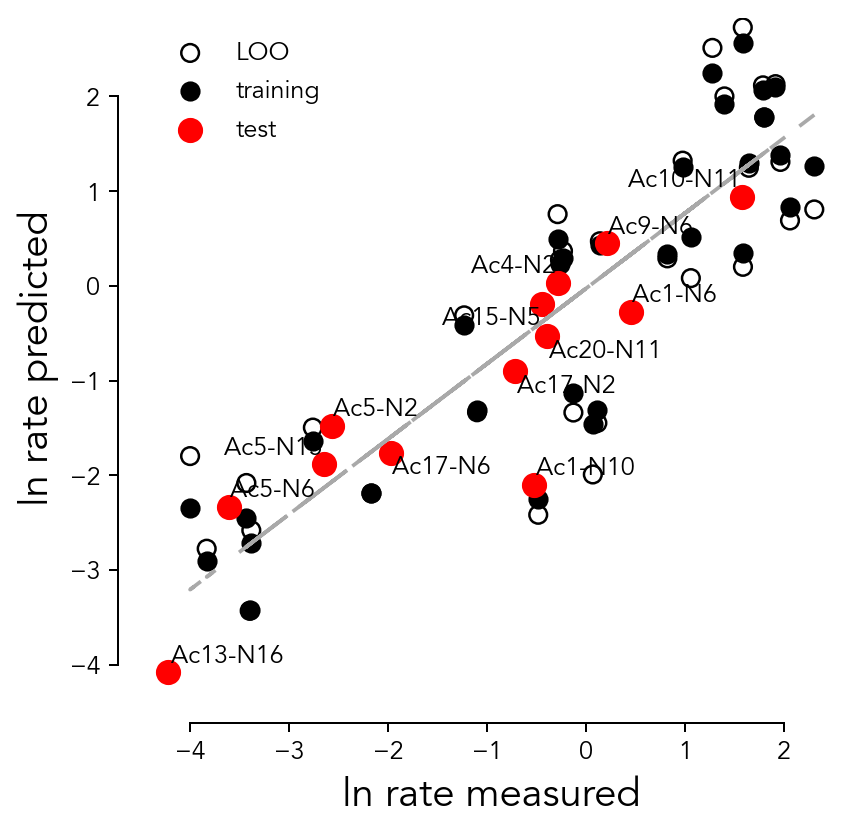

In [42]:
#provide an x__ model (string, any order of terms)

features_x =  "x80 + x108 + x44 + x40"
k_val = 4
features_py = sorted([X_labels.index(i.strip()) for i in features_x.split("+")])

# features_py = []
#features = sorted([int(i[1:]) for i in re.findall("x\d+",features_x)])
#features_py = [i-1 for i in features]

X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
lr = Ridge(alpha=1E-5).fit(X_train_sel, y_train)

#lr = LinearRegression().fit(X_train_sel, y_train)
alphas = np.logspace(-6,3,10)

#for i in alphas:
#lr = Ridge(alpha=i).fit(X_train_sel, y_train)     
#print(f'\nalpha: {i}')
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores = repeated_k_fold(X_train_sel,y_train,k=k_val,n=15504)

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training "+str(k_val)+"-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores.mean(), kfoldscores.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))

# settings for plot and saving
#plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav="plotname",label="$ΔΔG^{≠}$",loo_pred=loo_train)
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=True,
         label="ln rate",loo_pred=loo_train,VSlabels=[y_labels[i] for i in VS])
    

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
#print(model.summary())

### Add Features <a class="anchor" id="linear_manual_add"></a>

In [ ]:
# add all individual features to the manual model
add_df = pd.DataFrame(index=X_labelname,columns=["label_sep","label_abs","Training R2","Training Q2"],dtype=float)
skipfeatures = removed_feats

update_model = False
for f_ind in range(len(X_labels)):
    features_iter = features_py + [f_ind]    
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    add_df.iloc[f_ind,:] = [X_labels[f_ind],"x"+str(f_ind+1),lr.score(X_train_sel, y_train),q2]

if update_model and X_labelname.index(add_df['Training Q2'].idxmax()) not in features_py:
    features_py.append(X_labelname.index(add_df['Training Q2'].idxmax()))
add_df.sort_values(by=['Training Q2'],ascending=False).head(20)

,label_sep,label_abs,Training R2,Training Q2
x122 OccV C,x122,x122,0.866941,0.765708
x121 OccV B,x121,x121,0.846984,0.738432
x127 Occ Diff DB,x127,x127,0.831912,0.711455
x108 prox6_V RANGE,x108,x108,0.814635,0.697328
x61 ESA% rMIN,x61,x61,0.816832,0.696726
x17 ESA%,x17,x17,0.814381,0.694214
x83 ESA% rMAX,x83,x83,0.811923,0.691512
x58 catalyst_SA rMIN,x58,x58,0.812216,0.691505
x80 catalyst_SA rMAX,x80,x80,0.812216,0.691505
x14 catalyst_SA,x14,x14,0.812216,0.691505


### Remove Features <a class="anchor" id="linear_manual_del"></a>

In [ ]:
# remove each individual feature from the manual model
print("\n"+" + ".join(["x"+str(i+1) for i in sorted(features_py)]))

rem_df = pd.DataFrame(index=[X_labelname[i] for i in features_py],
                      columns=["Training R2","Training Q2"])
for f_ind in features_py:
    features_iter = [i for i in features_py if i != f_ind]
#     print(feature, x_names[f_ind])
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    rem_df.loc[X_labelname[f_ind],:] = [lr.score(X_train_sel, y_train),q2]

rem_df.sort_values(by=['Training Q2'],ascending=False)

## Multivariate Model Search <a class="anchor" id="linear_search"></a>

Step 1
Step 2
Finished 1 and 2 parameter models. Time taken (sec): 86.2481
Step 3
cutpar:  1
cutpar:  1
cutpar:  1
Step 4
cutpar:  1
cutpar:  1
cutpar:  1
Done. Time taken (minutes): 19.28

Split method: random
Test ratio: 0.28


Best model:
1 + x108 + x40 + x44 + x80
1 + Sterimol-B1-N1-C4_amine_boltz + NBO-C1 C=O_anion_boltz + IR-freq-CO2_asym-stretch_anion_boltz + E (LUMO)_amine_boltz

Features: x40 + x44 + x80 + x108

Parameters:
   -0.2444 + 
   -0.9689 * x40 NBO-C1 C=O_anion_boltz
    1.2336 * x44 NMR-C1 C=O_anion_boltz
    1.0836 * x80 IR-freq-C=O_interm_boltz
   -1.1117 * x108 Sterimol-B1-N1-C4_amine_boltz

Training R2  = 0.830
Training Q2  = 0.750
Training MAE = 0.643
Training 4-fold R2 = 0.731 (+/- 0.001)

Test R2      = 0.770
Test MAE     = 0.768


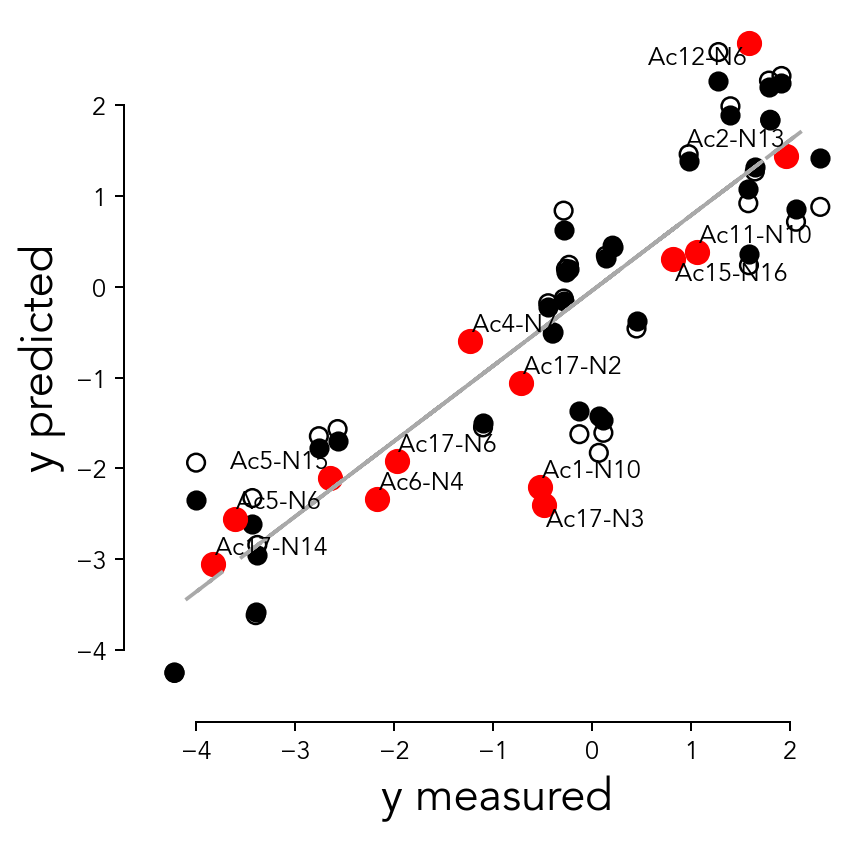

In [ ]:
# Forward stepwise selection keeping a set of candidates at each step
n_steps = 4  # Num of params in the model
k_val = 4
n_candidates = 200
collin_criteria = 0.5 # this is R2
skipfeatures = removed_feats #"x5","x6","x12","x13","x19","x20"

import ForwardStepCandidates_2 as fsc
df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
df.drop(skipfeatures,axis=1,inplace=True)

results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df,'y',
                    n_steps=n_steps,n_candidates=n_candidates,collin_criteria=collin_criteria)
model_sel = results.loc[0,"Model"]
selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print("\nBest model:")
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[candidates[0]].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
q2,loo_train = loo.q2(X_train_sel,y_train)
#kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=k_val,n=1184040)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=k_val,n=100)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training "+str(k_val)+"-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test,
         leg=False,sav=True,label="y",loo_pred=loo_train,
         VSlabels=[y_labels[i] for i in VS])

### Sort Models <a class="anchor" id="linear_search_sort"></a>

#### Sort by Training Correlation <a class="anchor" id="linear_search_sort_t"></a>

In [ ]:
# view best models
results.sort_values(by=['Q^2'],ascending=False).head(60)

### Uncomment below to export results in Excel ###
#results.to_excel('DuBois_Modeling_Correlations.xlsx')

,Model,n_terms,R^2,Q^2
0,"(x108, x128, x14, x78, x85)",5,0.735953,0.637162
1,"(x108, x14, x140, x78, x85)",5,0.741897,0.634780
2,"(x108, x41, x48, x6, x75)",5,0.714449,0.633553
3,"(x108, x128, x14, x78, x90)",5,0.731901,0.628482
4,"(x108, x113, x154, x37, x41)",5,0.723845,0.623312
5,"(x108, x128, x78, x80, x85)",5,0.743830,0.622971
6,"(x108, x133, x31, x78, x80)",5,0.714751,0.621596
7,"(x115, x2, x44, x48, x50)",5,0.705903,0.621479
8,"(x108, x125, x14, x78, x85)",5,0.726346,0.618992
9,"(x118, x2, x41, x48, x50)",5,0.711958,0.618702


#### Count Number of Times Each Feature Appears <a class="anchor" id="linear_search_count"></a>

In [ ]:
# Returns percent of models each feature appears in (recommended to use sorted model lists, but can use full list)

feature_count = {}
#model_list = results["Model"]
model_list = results.sort_values(by=['Q^2'],ascending=False).head(50)["Model"]

for model in model_list:
    for feature in model:
        if feature not in feature_count:
            feature_count[feature] = 1
        else:
            feature_count[feature] += 1
            
feature_count_ordered = dict(sorted(feature_count.items(), reverse=True, key=lambda item: item[1]))

for f in feature_count_ordered:
    print('Feature:',f,'appears in',str(round((int(feature_count[f])/len(model_list))*100)),'% of models')

Feature: x108 appears in 70 % of models
Feature: x78 appears in 52 % of models
Feature: x85 appears in 38 % of models
Feature: x14 appears in 26 % of models
Feature: x50 appears in 26 % of models
Feature: x48 appears in 24 % of models
Feature: x41 appears in 22 % of models
Feature: x2 appears in 22 % of models
Feature: x80 appears in 18 % of models
Feature: x115 appears in 14 % of models
Feature: x128 appears in 12 % of models
Feature: x6 appears in 12 % of models
Feature: x75 appears in 12 % of models
Feature: x113 appears in 12 % of models
Feature: x58 appears in 12 % of models
Feature: x90 appears in 10 % of models
Feature: x44 appears in 10 % of models
Feature: x125 appears in 10 % of models
Feature: x155 appears in 10 % of models
Feature: x140 appears in 8 % of models
Feature: x31 appears in 6 % of models
Feature: x137 appears in 6 % of models
Feature: x122 appears in 6 % of models
Feature: x37 appears in 4 % of models
Feature: x133 appears in 4 % of models
Feature: x118 appears i

#### Sort by Number of Terms <a class="anchor" id="linear_search_sort_n"></a>

In [ ]:
# view models with a specific number of terms
selmods = results[results.n_terms <=4].sort_values(by=['Q^2'],ascending=False)
selmods.head(50)

,Model,n_terms,R^2,Q^2
228,"(x14, x140, x78, x85)",4,0.653340,0.551537
233,"(x115, x2, x44, x50)",4,0.629383,0.551257
246,"(x125, x58, x78, x85)",4,0.629676,0.549748
292,"(x2, x41, x48, x50)",4,0.668309,0.547596
323,"(x2, x41, x45, x48)",4,0.653036,0.545797
333,"(x125, x14, x78, x85)",4,0.640936,0.545366
379,"(x140, x58, x78, x85)",4,0.630758,0.543541
391,"(x128, x14, x78, x85)",4,0.643483,0.542500
393,"(x128, x58, x78, x85)",4,0.629136,0.542329
419,"(x14, x34, x41, x6)",4,0.616838,0.541508


#### Find Least Offensive Models <a class="anchor" id="linear_search_sort_least"></a>

In [ ]:
# go through top 50 models
# identify models least likely to be ass
print('Running...')
print('')
for i in range(1,100):
    if i == 50:
        print('...Half-way through models...')
        
    model_sel = results.loc[i,"Model"]

    selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
    X_train_sel = X_train_sc[:,selected_feats]
    X_test_sel = X_test_sc[:,selected_feats]
    #print(models[model_sel].formula)
    #print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
    lr = LinearRegression().fit(X_train_sel,y_train)
    y_pred_train = lr.predict(X_train_sel)
    y_pred_test =  lr.predict(X_test_sel)

    q2,loo_train = loo.q2(X_train_sel,y_train)
    kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=3,n=300)

    testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
    trainr2 = lr.score(X_train_sel, y_train)
    if trainr2 - q2 <= 0.1 and trainr2 > 0.7 and testr2 > 0:
        print("\nModel "+str(i))
        print(f"Training R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
        print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

print('')
print('DONE')

Running...

...Half-way through models...

DONE


In [ ]:
# go through top 50 models
# identify models least likely to be ass
print('Running...')
print('')
for i in range(1,100):
    if i == 50:
        print('...Half-way through models...')
        
    model_sel = results.loc[i,"Model"]

    selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
    X_train_sel = X_train_sc[:,selected_feats]
    X_test_sel = X_test_sc[:,selected_feats]
    #print(models[model_sel].formula)
    #print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
    lr = LinearRegression().fit(X_train_sel,y_train)
    y_pred_train = lr.predict(X_train_sel)
    y_pred_test =  lr.predict(X_test_sel)

    q2,loo_train = loo.q2(X_train_sel,y_train)
    kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=3,n=3003)

    testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
    trainr2 = lr.score(X_train_sel, y_train)
    if testr2 >= 0.1:
        print("\nModel "+str(i))
        print(f"Training R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
        print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

print('')
print('DONE')

Running...


Model 3
Training R2  = 0.792
Training Q2  = 0.722

Test R2      = 0.036
Test MAE     = 0.352

Model 4
Training R2  = 0.794
Training Q2  = 0.720

Test R2      = 0.026
Test MAE     = 0.352

Model 8
Training R2  = 0.787
Training Q2  = 0.712

Test R2      = 0.001
Test MAE     = 0.360

Model 11
Training R2  = 0.784
Training Q2  = 0.710

Test R2      = 0.009
Test MAE     = 0.354

Model 12
Training R2  = 0.828
Training Q2  = 0.709

Test R2      = 0.131
Test MAE     = 0.322

Model 13
Training R2  = 0.780
Training Q2  = 0.708

Test R2      = 0.015
Test MAE     = 0.355

Model 15
Training R2  = 0.782
Training Q2  = 0.708

Test R2      = 0.019
Test MAE     = 0.354

Model 16
Training R2  = 0.790
Training Q2  = 0.707

Test R2      = 0.023
Test MAE     = 0.343

Model 17
Training R2  = 0.828
Training Q2  = 0.706

Test R2      = 0.116
Test MAE     = 0.323

Model 18
Training R2  = 0.779
Training Q2  = 0.706

Test R2      = 0.034
Test MAE     = 0.347

Model 19
Training R2  = 0.772
Training Q

### Filter by Feature <a class="anchor" id="linear_search_filter"></a>

In [ ]:
# example for filtering results
#vis_vol = ['x139','x140','x141','x142','x143','x144','x145','x146','x147','x148','x149','x150','x151','x152','x153','x154','x155','x156','x157','x158','x159','x160','x161','x162','x163']

#l1 = [*range(138, 163, 1)] 
#l2 = []
#for i in l1:
    #a = "x{}".format(i)
    #l2.append(a)

#selmods2 = results.loc[[i for i in results.index if "x200" not in results.loc[i,"Model"]]].sort_values(by=['Q^2'],ascending=False)

# less than 3 cross terms in model
#selmods2 = results.loc[[i for i in results.index if (sum(f in crossterms for f in results.loc[i,'Model']) < 2)]].sort_values(by=['Q^2'],ascending=False)
#selmods2 = results.loc[[i for i in results.index if (sum(f in l2 for f in results.loc[i,'Model']) < 3) and results.loc[i, 'n_terms'] < 4]].sort_values(by=['Q^2'],ascending=False)

#selmods2 = results.loc[[i for i in results.index if any(x in l2 for x in results.loc[i,'Model']) and "x200" not in results.loc[i,"Model"]]].sort_values(by=['Q^2'],ascending=False)
# example for filtering results
features = ['x116']

for f in features:
    #selmods2 = results.loc[[i for i in results.index if f in results.loc[i,"Model"] and "x69" in results.loc[i,"Model"]]][results.n_terms < 5].sort_values(by=['Q^2'],ascending=False)
    selmods2 = results.loc[[i for i in results.index if "x103" in results.loc[i,"Model"]]][results.n_terms < 5].sort_values(by=['Q^2'],ascending=False)
    #selmods2
    display(selmods2)

,Model,n_terms,R^2,Q^2
0,"(x1, x105, x116, x66)",4,0.904979,0.851338
1,"(x1, x105, x116, x93)",4,0.893879,0.836789
2,"(x1, x105, x116, x22)",4,0.905537,0.836199
3,"(x1, x105, x116, x88)",4,0.894506,0.834064
4,"(x1, x105, x116, x27)",4,0.900475,0.824304
...,...,...,...,...
11045,"(x116, x27, x92)",3,0.457019,-0.528838
11065,"(x116, x27, x58, x92)",4,0.485840,-0.543442
11245,"(x116, x87, x93)",3,0.515303,-0.982624
11247,"(x1, x116, x87)",3,0.443124,-0.988581


In [ ]:
# example for filtering results
SMART_boltz = ['x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25','x26','x27','x28','x29']
sphericity = ['x43']
sterimol_boltz = ['x16','x17','x18','x19','x20','x21','x22','x23']
sterimol_boltz = ['x16','x17','x18','x19','x20','x21','x22','x23']
ster_boltz_highR2 = ['x16','x17','x21']
ster_others_highR2 = ['x41','x33','x28','x52','x25','x45','x38','x54','x27']
ster_highR2 = ['x16','x17','x21','x41','x33','x28','x52','x25','x45','x38','x54','x27']
#l1 = [range(138, 163, 1)] 
#l2 = []
#for i in l1:
    #a = "x{}".format(i)
    #l2.append(a)

#selmods2 = results.loc[[i for i in results.index if "x200" not in results.loc[i,"Model"]]].sort_values(by=['Q^2'],ascending=False)

# less than 3 cross terms in model
#selmods2 = results.loc[[i for i in results.index if (sum(f in crossterms for f in results.loc[i,'Model']) < 2)]].sort_values(by=['Q^2'],ascending=False)
#selmods2 = results.loc[[i for i in results.index if (sum(f in l2 for f in results.loc[i,'Model']) < 3) and results.loc[i, 'n_terms'] < 4]].sort_values(by=['Q^2'],ascending=False)

selmods3 = results.loc[[i for i in results.index if any(x in SMART_boltz for x in results.loc[i,'Model']) and "x5" in results.loc[i,"Model"]]].sort_values(by=['Q^2'],ascending=False)
# example for filtering results
#selmods2 = results.loc[[i for i in results.index if "x9" in results.loc[i,"Model"] and "x8" not in results.loc[i,"Model"]]][results.n_terms < 5].sort_values(by=['Q^2'],ascending=False)
selmods3
selmods3.head(25)

,Model,n_terms,R^2,Q^2
1,"(x110, x27, x32, x5, x65)",5,0.808597,0.709016
2,"(x110, x21, x32, x5, x93)",5,0.796368,0.707741
5,"(x110, x21, x30, x5, x93)",5,0.777904,0.669805
6,"(x110, x21, x33, x5, x93)",5,0.777287,0.665754
7,"(x110, x27, x33, x5, x65)",5,0.794073,0.663819
13,"(x103, x115, x17, x5, x50)",5,0.799605,0.648558
14,"(x108, x117, x17, x5, x65)",5,0.772088,0.646392
15,"(x108, x118, x17, x5, x65)",5,0.762591,0.645622
22,"(x107, x108, x17, x5, x65)",5,0.772576,0.639856
24,"(x112, x22, x30, x5, x93)",5,0.741912,0.638300


In [ ]:
selmods4 = results.loc[[i for i in results.index if "x118" in results.loc[i,"Model"] and "x1" in results.loc[i,"Model"] and "x17" in results.loc[i,"Model"]]][results.n_terms < 5].sort_values(by=['Q^2'],ascending=False)
selmods4
selmods4.head(25)

,Model,n_terms,R^2,Q^2
9,"(x1, x106, x118, x17)",4,0.831954,0.728327
23,"(x1, x118, x17, x98)",4,0.828066,0.715670
24,"(x1, x105, x118, x17)",4,0.827971,0.715553
128,"(x1, x118, x17, x99)",4,0.783606,0.666284
377,"(x1, x103, x118, x17)",4,0.787991,0.633127
485,"(x1, x107, x118, x17)",4,0.774042,0.625066
566,"(x1, x102, x118, x17)",4,0.780100,0.619641
2834,"(x1, x118, x17)",3,0.595775,0.445946


In [ ]:
selmods4 = results.loc[[i for i in results.index if "x118" in results.loc[i,"Model"] and "x1" in results.loc[i,"Model"]]][results.n_terms < 5].sort_values(by=['Q^2'],ascending=False)
selmods4
selmods4.head(50)

,Model,n_terms,R^2,Q^2
4,"(x1, x105, x118, x59)",4,0.835611,0.739076
5,"(x1, x105, x118, x15)",4,0.833031,0.732152
6,"(x1, x106, x118, x59)",4,0.829921,0.729638
7,"(x1, x106, x118, x61)",4,0.833010,0.729361
9,"(x1, x106, x118, x17)",4,0.831954,0.728327
11,"(x1, x106, x118, x83)",4,0.830760,0.726648
12,"(x1, x118, x59, x98)",4,0.829456,0.725707
13,"(x1, x105, x118, x81)",4,0.830694,0.725621
14,"(x1, x106, x118, x15)",4,0.828376,0.725456
17,"(x1, x106, x118, x81)",4,0.826955,0.721454


In [ ]:
selmods5 = results.loc[[i for i in results.index if "x7" in results.loc[i,"Model"] and "x108" not in results.loc[i,"Model"]]][results.n_terms < 6].sort_values(by=['Q^2'],ascending=False)
selmods5

,Model,n_terms,R^2,Q^2
181,"(x11, x27, x31, x7)",4,0.862891,0.760365
192,"(x101, x11, x31, x7)",4,0.859972,0.758015
200,"(x11, x31, x7, x93)",4,0.860800,0.756460
208,"(x27, x31, x7, x77)",4,0.851661,0.754869
209,"(x31, x7, x77, x93)",4,0.850477,0.754455
...,...,...,...,...
8212,"(x31, x58, x7)",3,0.287543,-0.805110
8213,"(x26, x31, x7)",3,0.248853,-0.805515
8220,"(x31, x7, x98)",3,0.283525,-0.839350
8221,"(x106, x31, x7)",3,0.274866,-0.851212


1 + x30 + x4 + x47 + x48

Parameters:
    0.9434 + 
   -0.1349 * x4 RhRh BD
   -0.1625 * x30 G% Rh  WSD
    0.2596 * x47 prox7_V  WSD
   -0.2907 * x48 prox7_sphericity WSD

Training R2  = 0.799
Training Q2  = 0.675
Training MAE = 0.120
Training K-fold R2 = -6.656 (+/- 2803.238)

Test R2      = 0.197
Test MAE     = 0.316

yikes. that's ass


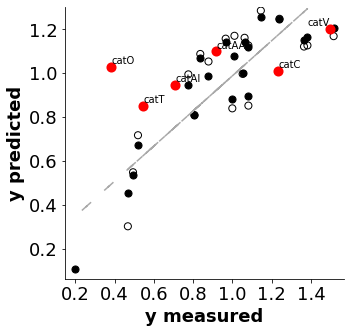

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     14.95
Date:                Mon, 04 Jul 2022   Prob (F-statistic):           4.09e-05
Time:                        16:05:39   Log-Likelihood:                 10.123
No. Observations:                  20   AIC:                            -10.25
Df Residuals:                      15   BIC:                            -5.268
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9434      0.038     25.050      0.0

In [ ]:
model_sel = results.loc[96,"Model"]

selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
#selected_feats = sorted([X_labels[int(i[1:])-1] for i in models[model_sel].terms])

X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
print(models[model_sel].formula)
#print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=4,n=15504)

#print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")


testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.3:
    print("\nyikes. that's ass")

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train,VSlabels=[y_labels[i] for i in VS])
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

### View Other Models <a class="anchor" id="linear_search_view"></a>

model_sel = results.loc[5,"Model"]

selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
#selected_feats = sorted([X_labels[int(i[1:])-1] for i in models[model_sel].terms])

X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
print(models[model_sel].formula)
#print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=3,n=3003)

#print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")


testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.3:
    print("\nyikes. that's ass")

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train,VSlabels=[y_labels[i] for i in VS])
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

## Other <a class="anchor" id="other"></a>

## Ridge Regression <a class="anchor" id="linear_ridge"></a>

0.0001
     Training R2;Training Q2;Test R2;1.00;-0.66;-2.76
0.001
     Training R2;Training Q2;Test R2;1.00;-0.66;-2.76
0.01
     Training R2;Training Q2;Test R2;1.00;-0.66;-2.74
0.1
     Training R2;Training Q2;Test R2;1.00;-0.66;-2.60
1.0
     Training R2;Training Q2;Test R2;0.99;-0.56;-1.81
10.0
     Training R2;Training Q2;Test R2;0.90;-0.15;-0.70
100.0
     Training R2;Training Q2;Test R2;0.61;-0.13;-0.06
1000.0
     Training R2;Training Q2;Test R2;0.23;-0.10;0.02
10000.0
     Training R2;Training Q2;Test R2;0.04;-0.07;0.01


Using hyperparameter = 10000.0


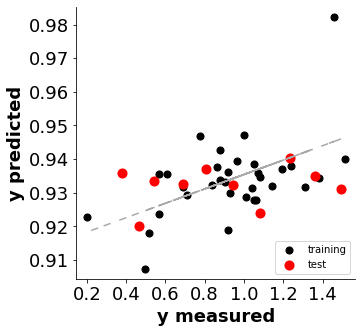

In [ ]:
linm = Ridge().fit(X_train_sc, y_train)

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,4,9)
for parm in parm_range:
    print(parm)
    linm = Ridge(alpha=parm).fit(X_train_sc, y_train)
    q2,loo_train = loo.q2(X_train_sc,y_train,Ridge(alpha=parm))
    
    y_pred_train = linm.predict(X_train_sc)
    y_pred_test =  linm.predict(X_test_sc)
    #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(linm.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
        
    r2s.append(linm.score(X_train_sc, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
linm = Ridge(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = linm.predict(X_train_sc)
y_pred_test =  linm.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

## Lasso Feature Selection <a class="anchor" id="linear_lasso"></a>

0.0001
     Training R2;Training Q2;Test R2;1.00;0.41;-2.90
     Number of features used: 80
0.001
     Training R2;Training Q2;Test R2;1.00;-0.87;-1.64
     Number of features used: 34
0.01
     Training R2;Training Q2;Test R2;0.93;0.08;-1.18
     Number of features used: 19
0.1
     Training R2;Training Q2;Test R2;0.39;0.14;-0.05
     Number of features used: 2
1.0
     Number of features used: 0
10.0
     Number of features used: 0


Using hyperparameter = 0.0001


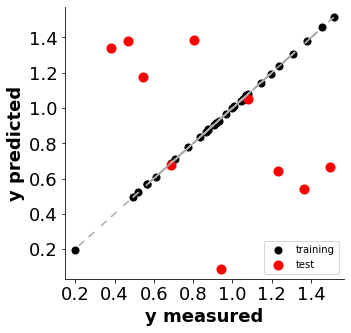



LassoLarsCV
Training R2;Training Q2;Test R2;0.24;0.25;-2.62
Number of features used: 3


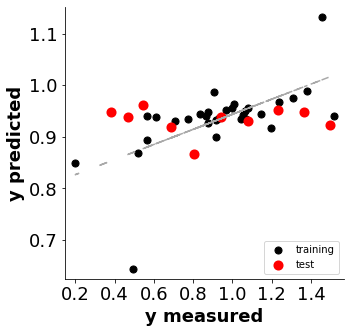

In [ ]:
# Lasso feature selection

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,1,6)
for parm in parm_range:
    print(parm)
    lasso = Lasso(alpha=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(lasso.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(lasso.coef_!=0)[0]]
    try:
        q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
        lr = LinearRegression().fit(X_train_sel,y_train)
        y_pred_train = lr.predict(X_train_sel)
        y_pred_test =  lr.predict(X_test_sel)
        #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
        print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
        #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
    except:
        pass
    print("     Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
    # print(np.where(lr.coef_ != 0)[1])
    
    r2s.append(lasso.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
lasso = Lasso(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = lasso.predict(X_train_sc)
y_pred_test =  lasso.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    
    
# llbic = LassoLarsIC(criterion="bic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llbic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llbic.coef_!=0)[0]]
# print("\n\nLassoLarsIC bic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llbic.score(X_train_sc, y_train),q2,llbic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llbic.coef_ != 0)))

# llaic = LassoLarsIC(criterion="aic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llaic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llaic.coef_!=0)[0]]
# print("\n\nLassoLarsIC aic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llaic.score(X_train_sc, y_train),q2,llaic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llaic.coef_ != 0)))

# lassocv = LassoCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(lassocv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(lassocv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nLassoCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lassocv.score(X_train_sc, y_train),q2,lassocv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(lassocv.coef_ != 0)))
# print(np.where(lassocv.coef_ != 0)[1])

llcv = LassoLarsCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(llcv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(llcv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
print("\n\nLassoLarsCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llcv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(llcv.coef_ != 0)))
# print(np.where(llcv.coef_ != 0)[1])
y_pred_train = llcv.predict(X_train_sc)
y_pred_test =  llcv.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    

## Elastic Net <a class="anchor" id="linear_elastic"></a>

In [ ]:
%%time
encv = ElasticNetCV(l1_ratio=[.01,.05,.66,.1,.2,.3, .5, .7, .9, .95, .99, 1],
#                     n_alphas=500,
                    alphas=np.logspace(-1,4,100),
                    cv=3,n_jobs=-1,max_iter=1000000).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(encv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(encv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,Ridge(alpha=encv.alpha_))
y_pred_train = encv.predict(X_train_sc)
y_pred_test =  encv.predict(X_test_sc)
print("\n\nElasticNetCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(encv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(encv.coef_ != 0)))
print("Best hyperparameters: l1_ratio = {}, alpha = {}".format(encv.l1_ratio_,encv.alpha_))


plot_fit(y_train,y_pred_train,y_test,y_pred_test) 

ValueError: Found array with 0 feature(s) (shape=(32, 0)) while a minimum of 1 is required.

## Orthogonal Matching Pursuit <a class="anchor" id="linear_orthog"></a>

In [ ]:
# Orthogonal Matching Pursuit

parm_range = range(1,163)
print(np.shape(X_train_sc))
print(np.shape(y_train))
for parm in parm_range:
    print(parm)
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(omp.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(omp.coef_!=0)[0]]
    q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
    y_pred_train = omp.predict(X_train_sc)
    y_pred_test =  omp.predict(X_test_sc)
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(omp.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

    print("     "+" + ".join(["x"+str(i+1) for i in np.where(omp.coef_ != 0)[0]]))
    #print("     Number of features used: {}".format(np.sum(lr.coef_ != 0)))
    

# ompcv = OrthogonalMatchingPursuitCV(cv=LeaveOneOut(),n_jobs=-1).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(ompcv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(ompcv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nOrthogonalMatchingPursuitCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(ompcv.score(X_train_sc, y_train),q2,ompcv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(ompcv.coef_ != 0)))

# print("\n"+" + ".join(["x"+str(i+1) for i in np.where(ompcv.coef_!=0)[0]]))
# print("\n"+" + ".join([X_names[i] for i in np.where(ompcv.coef_!=0)[0]]))

# y_pred_train = ompcv.predict(X_train_sc)
# y_pred_test =  ompcv.predict(X_test_sc)
# plot_fit(y_train,y_pred_train,y_test,y_pred_test)


(33, 163)
(33,)
1
     Training R2;Training Q2;Test R2;0.30;0.06;0.01
     x115
2
     Training R2;Training Q2;Test R2;0.40;0.17;-0.34
     x108 + x115
3
     Training R2;Training Q2;Test R2;0.53;0.27;-1.10
     x50 + x108 + x115
4
     Training R2;Training Q2;Test R2;0.59;0.31;-1.07
     x47 + x50 + x108 + x115
5
     Training R2;Training Q2;Test R2;0.68;0.54;-0.89
     x41 + x47 + x50 + x108 + x115
6
     Training R2;Training Q2;Test R2;0.74;0.61;-0.86
     x41 + x47 + x50 + x108 + x115 + x150
7
     Training R2;Training Q2;Test R2;0.76;0.62;-0.80
     x20 + x41 + x47 + x50 + x108 + x115 + x150
8
     Training R2;Training Q2;Test R2;0.78;0.63;-0.92
     x20 + x41 + x47 + x50 + x108 + x115 + x134 + x150
9
     Training R2;Training Q2;Test R2;0.80;0.61;-0.91
     x20 + x31 + x41 + x47 + x50 + x108 + x115 + x134 + x150
10
     Training R2;Training Q2;Test R2;0.81;0.58;-0.96
     x5 + x20 + x31 + x41 + x47 + x50 + x108 + x115 + x134 + x150
11
     Training R2;Training Q2;Test R2;0.83;0.3

     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
52
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
53
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
54
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x1

     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
85
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
86
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
87
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x1

     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
119
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
120
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
121
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 +

     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
152
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
153
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 + x115 + x117 + x120 + x134 + x136 + x143 + x144 + x147 + x148 + x150 + x163
154
     Training R2;Training Q2;Test R2;1.00;-1.26;-14.53
     x1 + x3 + x5 + x6 + x7 + x20 + x30 + x31 + x35 + x38 + x41 + x47 + x50 + x52 + x60 + x77 + x87 + x97 + x100 + x107 + x108 + x109 +

# Non-Linear Modeling <a class="anchor" id="nonlinear"></a>



KernelRidge
0.001
     Training R2;Training Q2;Test R2;1.00;-0.38;-1.55
0.01
     Training R2;Training Q2;Test R2;1.00;-0.34;-1.39
0.1
     Training R2;Training Q2;Test R2;0.97;-0.28;-0.77
1.0
     Training R2;Training Q2;Test R2;0.77;-0.27;-0.23
10.0
     Training R2;Training Q2;Test R2;-0.12;-0.90;-0.34
100.0
     Training R2;Training Q2;Test R2;-5.46;-6.18;-3.17
1000.0
     Training R2;Training Q2;Test R2;-9.83;-9.99;-5.51


Using hyperparameter = 1.0


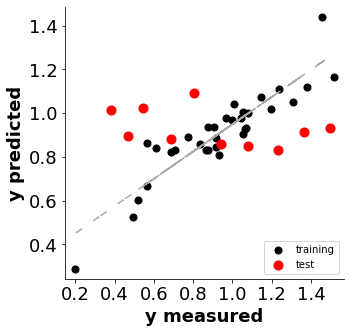

In [ ]:
# Kernel Ridge Regression 
# kernel options: linear, poly, rbf

r2s = []
q2s = []
parms = []
print("\n\nKernelRidge")

kernel="poly" #rbf (only works if properties are related)
degree=2  #2 simulates crossterms 

parm_range = np.logspace(-3,3,7)
for parm in parm_range:
    print(parm)
    kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=parm
    ).fit(X_train_sc, y_train)
    y_pred_train = kr.predict(X_train_sc)
    y_pred_test =  kr.predict(X_test_sc)
    q2,loo_train = loo.q2(X_train_sc,y_train,KernelRidge(kernel=kernel,degree=degree,alpha=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        kr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(kr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = kr.predict(X_train_sc)
y_pred_test =  kr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)




Support Vector Regression
1.00E-03
     Training R2;Training Q2;Test R2;0.01;-0.03;-0.02
2.68E-03
     Training R2;Training Q2;Test R2;0.05;-0.03;-0.02
7.20E-03
     Training R2;Training Q2;Test R2;0.11;-0.04;-0.03
1.93E-02
     Training R2;Training Q2;Test R2;0.18;-0.03;-0.05
5.18E-02
     Training R2;Training Q2;Test R2;0.32;-0.06;-0.07
1.39E-01
     Training R2;Training Q2;Test R2;0.53;-0.17;-0.11
3.73E-01
     Training R2;Training Q2;Test R2;0.64;-0.31;-0.19
1.00E+00
     Training R2;Training Q2;Test R2;0.75;-0.89;-0.39
2.68E+00
     Training R2;Training Q2;Test R2;0.85;-1.53;-0.63
7.20E+00
     Training R2;Training Q2;Test R2;0.88;-1.35;-1.14
1.93E+01
     Training R2;Training Q2;Test R2;0.90;-1.65;-1.85
5.18E+01
     Training R2;Training Q2;Test R2;0.90;-1.65;-1.85
1.39E+02
     Training R2;Training Q2;Test R2;0.90;-1.65;-1.85
3.73E+02
     Training R2;Training Q2;Test R2;0.90;-1.65;-1.85
1.00E+03
     Training R2;Training Q2;Test R2;0.90;-1.65;-1.85


Using hyperparameter = 0.

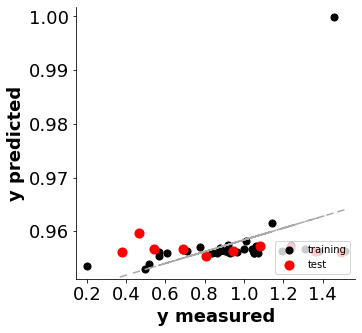

In [ ]:
# SVR

r2s = []
q2s = []
parms = []
print("\n\nSupport Vector Regression")

kernel="poly"
degree=2
gamma="auto"

parm_range = np.logspace(-3,3,15)
for parm in parm_range:
    print("{:.2E}".format(parm))
    svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=parm
    ).fit(X_train_sc, y_train)
    y_pred_train = svr.predict(X_train_sc)
    y_pred_test =  svr.predict(X_test_sc)
    q2,loo_train = loo.q2(X_train_sc,y_train,SVR(kernel=kernel,degree=degree,gamma=gamma,C=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        svr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(svr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = svr.predict(X_train_sc)
y_pred_test =  svr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)
   

# keepmodels_[svr] = ()



PC Regression 1
Training R2;Training Q2;Test R2;0.06;-0.12;0.11


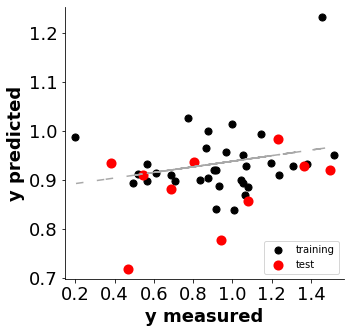



PC Regression 2
Training R2;Training Q2;Test R2;0.06;-0.25;0.11


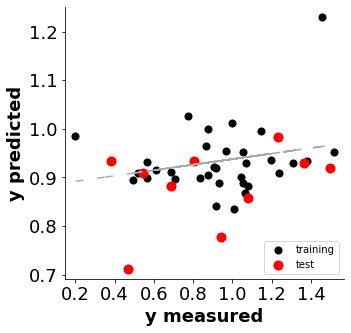



PC Regression 3
Training R2;Training Q2;Test R2;0.08;-0.32;-0.40


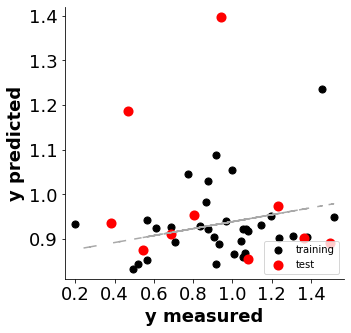



PC Regression 4
Training R2;Training Q2;Test R2;0.08;-0.75;-0.40


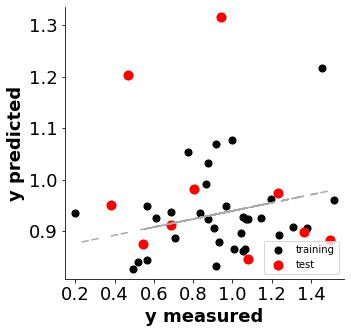



PC Regression 5
Training R2;Training Q2;Test R2;0.20;-0.65;-1.36


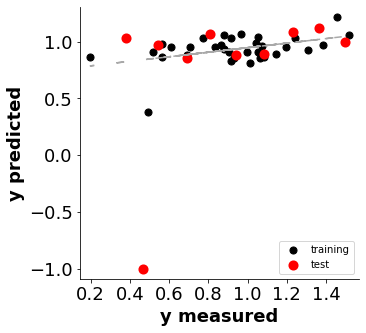



PC Regression 6
Training R2;Training Q2;Test R2;0.25;-0.73;-1.17


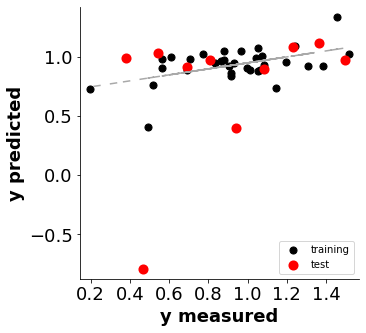



PC Regression 7
Training R2;Training Q2;Test R2;0.25;-1.25;-1.17


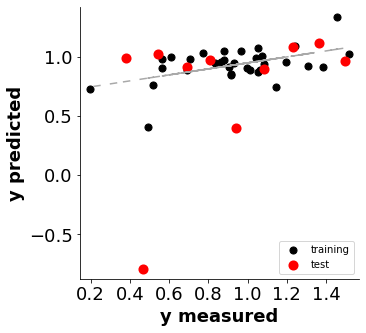



PC Regression 8
Training R2;Training Q2;Test R2;0.25;-1.64;-1.23


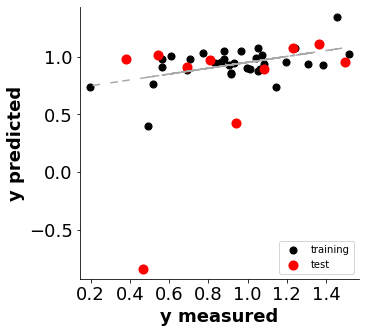

In [ ]:
# Regression with Principal Components

for npca in range(1,9):
    pca = PCA(n_components=npca)
    pca.fit(scaler.transform(X_sel))
#     pca.fit(X_train_sc)
    X_train_pca = pca.transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)

    pca_score = pca.explained_variance_ratio_
    pca_values = pca.singular_values_
    V = pca.components_

    linr = LinearRegression().fit(X_train_pca, y_train)
#     linr = Ridge(alpha=1).fit(X_train_pca,y_train)
    y_pred_train = linr.predict(X_train_pca)
    y_pred_test =  linr.predict(X_test_pca)
    q2,loo_train = loo.q2(X_train_pca,y_train,LinearRegression())
    print("\n\nPC Regression {}".format(npca))
    print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        linr.score(X_train_pca, y_train),q2,r2_val(y_test,y_pred_test,y_train)))



    plot_fit(y_train,y_pred_train,y_test,y_pred_test)

    
# # virtual screening
# X_screen_sel = pca.transform(X_all_sc)
# y_pred_vscreen = linr.predict(X_screen_sel)
# y_vscreen["PCA5"] = y_pred_vscreen


# keepmodels_[PCA(n_components=2).fit(scaler.transform(X_sel))] = ("n_components=2")

## Gaussian Process Regression <a class="anchor" id="gauss"></a>

In [ ]:
# just for shits

import sklearn.gaussian_process as gp

#skipfeatures = removed_feats
#df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
#newcols = ["x"+str(i+1) for i in df.columns.values]
#df.columns = newcols
#response = newcols[-1]
#df.rename(columns={response:"y"},inplace=True)
#df.drop(skipfeatures,axis=1,inplace=True)

X_tr = X_train_sc  #<-- training observations [# points, # features]
y_tr = y_train     #<-- training labels [# points]
X_te = X_test_sc   #<-- test observations [# points, # features]
y_te = y_test      #<-- test labels

print(len(X_tr))
print(len(y_tr))
print(len(X_te))
print(len(y_te))

kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
model.fit(df, y_tr)
params = model.kernel_.get_params()

print(model)
#y_pred, std = model.predict(X_te, return_std=True)

#MSE = ((y_pred-y_te)**2).mean()


20
20
6
6
GaussianProcessRegressor(alpha=0.1, kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10, normalize_y=True)
